# Predcition of Hospital Admission Related to Pneumonia

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to pneumonia.

In [37]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [38]:
# def create_lineplot(data, var, title, legend_title, ax1):
def create_lineplot(data, var, title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    # a.Freq = a.Freq*1000
    a = a[a.Freq > 5]
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Count')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
#     ax1.legend(title=legend_title)
    # ax1.grid()
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)

In [39]:
# function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [40]:
def round_five_mul(x, base=5):
    return base * round(x/base)

In [41]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'pneumonia_date_'+str(i), 'pneumonia_ab_date_'+str(i), 'pneumonia_ab_type_'+str(i),
                   'incdt_pneumonia_date_'+str(i), 'admitted_pneumonia_date_'+str(i), 'sgss_gp_cov_pneumonia_date_'+str(i)]]
    
    #drop rows with no pneumonia reord
    datum = datum[datum['pneumonia_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with pneumonia_i
    datum = datum[datum['sgss_gp_cov_pneumonia_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'pneumonia_date_'+str(i): 'pneumonia_date', 'pneumonia_ab_date_'+str(i): 'pneumonia_ab_date', 
                           'pneumonia_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_pneumonia_date_'+str(i): 'incdt_pneumonia_date', 'incdt_pneumonia_type_'+str(i): 'incdt_pneumonia_type',
                           'admitted_pneumonia_date_'+str(i): 'admitted_pneumonia_date',
                           'sgss_gp_cov_pneumonia_date_'+str(i): 'sgss_gp_cov_pneumonia_date'},
                inplace=True)
    
    return datum

In [42]:
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    # data_req = data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit',
    #              'event_pneumonia_admitted', 'duration_pneumonia_admitted']]
    data_req = data[vars+vars_countinuous+vars_output]

    # encoding categorical data for CPH
    # data_enc = data_req[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']].reset_index()
    data_enc = data_req[vars+vars_countinuous].reset_index()
    # data_enc

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_enc)
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [43]:
def make_summary_table(infection, infection_type, data):
    #summary table
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'
    # summary_table

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [44]:
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    # encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period', 'antibacterial_brit']].reset_index()
    # data_hosped

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_hosped)
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    # data_hosped_enc#.head()
    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'
    # summary_table_hosped

    # save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [45]:
def cox_model_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #calculate and save ci
    ci = cph.concordance_index_
    a = open('../output/hospitalisation_prediction_'+infection+'/'+infection+'_'+infection_type+'_ci.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (ci)])

    return cph, data_train, data_test

In [46]:
def betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):

    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    # covariates.shape

    # save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv(directory+'hazard_ratios_'+betas_name, index=False)

    # transpose and sort covariates and coefficients
    covariatesT = covariates.T
    # covariatesT.covariate = covariates
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data
    # covariatesT.shape

    # further cleaning up covariates to make them compatible with the encoded data
    mylist = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    mylist = [value.replace("'", "") for value in mylist] #removes double quotation mark 

    #match mylist (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(mylist)] 
    data = data.sort_index(axis = 1) #sort 
    # data.shape

    # multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')
    # betas

    # sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    # sum_betas
#######################################################
    # predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas
    # sum_betas_hazard

    #drop rows with predicted risks greater than 99th percentile of all risks
    sum_betas_hazard = sum_betas_hazard[sum_betas_hazard[30] <= sum_betas_hazard[30].quantile(0.99)]  
    # return sum_betas_hazard

    # sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])
    # sum_betas_hazard

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas
    # sum_betas_hazard

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()
    # sum_betas_hazard_groupby

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    # separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))
    # sum_betas_hazard_groupby.head()

    # select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]

    # save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [47]:
def cph_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    # analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_train_cumulative_hazard

    # analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_test_cumulative_hazard

    # plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='Cox with development data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='Cox with validation data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    # plt.title('', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    # plt.tight_layout()
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

In [48]:
def cph_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']
    # prob_pred_true_train

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)
    # prob_pred_true_train

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)
    # prob_pred_true_train

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']
    # prob_pred_true_train_groupby_bin

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']
    # prob_pred_true_train_groupby_bin
############
    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T #[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']]).loc[[30]].T#.reset_index(drop=True)
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']
    # prob_pred_true_test_groupby_bin
###################
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

In [49]:
def cph_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    # calculate concordance index, AUROC, and Brier score of cph model
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    # save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [50]:
def cox_model_abs_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + pneumonia_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [51]:
def cox_model_ab_type_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ab_type_cat"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [52]:
def cox_model_strat_sex_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + pneumonia_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [53]:
def cox_model_strat_age_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + pneumonia_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

## 1- data preparation

In [54]:
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_pneumonia.csv.gz')

data.shape

(200000, 224)

In [55]:
# save model outputs
a = open("../output/hospitalisation_prediction_pneumonia/data_pneumonia_record_cph_pneumonia.txt", "w")
a.write("")
a.writelines(['data_pneumonia_1 #with a record, #with no record: %.0f' % (data['pneumonia_date_1'].notna().sum()), ', %.0f' % (data['pneumonia_date_1'].isna().sum()),
              '\ndata_pneumonia_2 #with a record, #with no record: %.0f' % (data['pneumonia_date_2'].notna().sum()), ', %.0f' % (data['pneumonia_date_2'].isna().sum()),
              '\ndata_pneumonia_3 #with a record, #with no record: %.0f' % (data['pneumonia_date_3'].notna().sum()), ', %.0f' % (data['pneumonia_date_3'].isna().sum()),
              '\ndata_pneumonia_4 #with a record, #with no record: %.0f' % (data['pneumonia_date_4'].notna().sum()), ', %.0f' % (data['pneumonia_date_4'].isna().sum()),
              '\ndata_pneumonia_5 #with a record, #with no record: %.0f' % (data['pneumonia_date_5'].notna().sum()), ', %.0f' % (data['pneumonia_date_5'].isna().sum()),
              '\ndata_pneumonia_6 #with a record, #with no record: %.0f' % (data['pneumonia_date_6'].notna().sum()), ', %.0f' % (data['pneumonia_date_6'].isna().sum()),
              '\ndata_pneumonia_7 #with a record, #with no record: %.0f' % (data['pneumonia_date_7'].notna().sum()), ', %.0f' % (data['pneumonia_date_7'].isna().sum()),
              '\ndata_pneumonia_8 #with a record, #with no record: %.0f' % (data['pneumonia_date_8'].notna().sum()), ', %.0f' % (data['pneumonia_date_8'].isna().sum()),
              '\ndata_pneumonia_9 #with a record, #with no record: %.0f' % (data['pneumonia_date_9'].notna().sum()), ', %.0f' % (data['pneumonia_date_9'].isna().sum()),
              '\ndata_pneumonia_10 #with a record, #with no record: %.0f' % (data['pneumonia_date_10'].notna().sum()), ', %.0f' % (data['pneumonia_date_10'].isna().sum()),
              '\ndata_pneumonia_11 #with a record, #with no record: %.0f' % (data['pneumonia_date_11'].notna().sum()), ', %.0f' % (data['pneumonia_date_11'].isna().sum()),
              '\ndata_pneumonia_12 #with a record, #with no record: %.0f' % (data['pneumonia_date_12'].notna().sum()), ', %.0f' % (data['pneumonia_date_12'].isna().sum()),
              '\ndata_pneumonia_13 #with a record, #with no record: %.0f' % (data['pneumonia_date_13'].notna().sum()), ', %.0f' % (data['pneumonia_date_13'].isna().sum()),
              '\ndata_pneumonia_14 #with a record, #with no record: %.0f' % (data['pneumonia_date_14'].notna().sum()), ', %.0f' % (data['pneumonia_date_14'].isna().sum()),
              '\ndata_pneumonia_15 #with a record, #with no record: %.0f' % (data['pneumonia_date_15'].notna().sum()), ', %.0f' % (data['pneumonia_date_15'].isna().sum()),
              '\ndata_pneumonia_16 #with a record, #with no record: %.0f' % (data['pneumonia_date_16'].notna().sum()), ', %.0f' % (data['pneumonia_date_16'].isna().sum()),
              '\ndata_pneumonia_17 #with a record, #with no record: %.0f' % (data['pneumonia_date_17'].notna().sum()), ', %.0f' % (data['pneumonia_date_17'].isna().sum()),
              '\ndata_pneumonia_18 #with a record, #with no record: %.0f' % (data['pneumonia_date_18'].notna().sum()), ', %.0f' % (data['pneumonia_date_18'].isna().sum()),
              '\ndata_pneumonia_19 #with a record, #with no record: %.0f' % (data['pneumonia_date_19'].notna().sum()), ', %.0f' % (data['pneumonia_date_19'].isna().sum()),
              '\ndata_pneumonia_20 #with a record, #with no record: %.0f' % (data['pneumonia_date_20'].notna().sum()), ', %.0f' % (data['pneumonia_date_20'].isna().sum()),
              ])

### 1-2- additional variables
Calculating Charlson Comorbidity Index based on https://www.nature.com/articles/4500889.pdf?origin=ppub

In [56]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')


for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, col15] == 1: # mi_comor
        n=n+1
    if data.iat[idx, col2] == 1: # cardiovascular_comor
        n=n+1 
    if data.iat[idx, col17] == 1: # peripheral_vascular_comor
        n=n+1 
    if data.iat[idx, col3] == 1: # chronic_obstructive_pulmonary_comor
        n=n+1
    if data.iat[idx, col7] == 1: # diabetes_comor
        n=n+1
    if data.iat[idx, col6] == 1: # dementia_comor
        n=n+1
    if data.iat[idx, col16] == 1: # peptic_ulcer_comor
        n=n+1
    if data.iat[idx, col5] == 1: # connective_tissue_comor
        n=n+1
    if data.iat[idx, col12] == 1: # mild_liver_comor
        n=n+1
    if data.iat[idx, col9] == 1: # hemiplegia_comor
        n=n+2
    if data.iat[idx, col14] == 1: # mod_severe_renal_comor
        n=n+2
    if data.iat[idx, col8] == 1: # diabetes_complications_comor
        n=n+2
    if data.iat[idx, col1] == 1: # cancer_comor
        n=n+2
    if data.iat[idx, col13] == 1: # mod_severe_liver_comor
        n=n+3
    if data.iat[idx, col11] == 1: # metastatic_cancer_comor
        n=n+6
    if data.iat[idx, col10] == 1: # hiv_comor
        n=n+6
    
    data.iat[idx, col0]=n

data.CCI.value_counts()

0.0     37071
1.0     37056
2.0     33167
3.0     24729
4.0     14949
6.0     12099
7.0     10098
5.0      8218
8.0      8049
9.0      5719
10.0     3396
11.0     1890
12.0     1384
13.0      891
14.0      545
15.0      350
16.0      192
17.0      111
18.0       46
19.0       25
20.0        7
21.0        7
24.0        1
Name: CCI, dtype: int64

## 2- data preparation
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission.

### 2-1- gathering data

In [57]:
#read 20 pneumonias and concatenate them 
data_pneumonia_1 = proc_infec_data(data,1)
data_pneumonia_2 = proc_infec_data(data,2)
data_pneumonia_3 = proc_infec_data(data,3)
data_pneumonia_4 = proc_infec_data(data,4)
data_pneumonia_5 = proc_infec_data(data,5)
data_pneumonia_6 = proc_infec_data(data,6)
data_pneumonia_7 = proc_infec_data(data,7)
data_pneumonia_8 = proc_infec_data(data,8)
data_pneumonia_9 = proc_infec_data(data,9)
data_pneumonia_10 = proc_infec_data(data,10)
data_pneumonia_11 = proc_infec_data(data,11)
data_pneumonia_12 = proc_infec_data(data,12)
data_pneumonia_13 = proc_infec_data(data,13)
data_pneumonia_14 = proc_infec_data(data,14)
data_pneumonia_15 = proc_infec_data(data,15)
data_pneumonia_16 = proc_infec_data(data,16)
data_pneumonia_17 = proc_infec_data(data,17)
data_pneumonia_18 = proc_infec_data(data,18)
data_pneumonia_19 = proc_infec_data(data,19)
data_pneumonia_20 = proc_infec_data(data,20)

data_pneumonia = pd.concat([data_pneumonia_1, data_pneumonia_2, data_pneumonia_3, data_pneumonia_4, data_pneumonia_5, data_pneumonia_6, data_pneumonia_7, data_pneumonia_8, data_pneumonia_9, data_pneumonia_10, data_pneumonia_11, data_pneumonia_12, data_pneumonia_13, data_pneumonia_14, data_pneumonia_15, data_pneumonia_16, data_pneumonia_17, data_pneumonia_18, data_pneumonia_19, data_pneumonia_20])
data_pneumonia.reset_index(inplace=True, drop=True)
data_pneumonia.shape

(360164, 20)

### 2-2- add season, event, and duration variables
#### season

In [58]:
# convert data types
data_pneumonia['pneumonia_date'] = data_pneumonia['pneumonia_date'].astype('datetime64[ns]')
data_pneumonia['admitted_pneumonia_date'] = data_pneumonia['admitted_pneumonia_date'].astype('datetime64[ns]')
data_pneumonia.died_date = data_pneumonia.died_date.astype('datetime64[ns]')
data_pneumonia.deregistered_date = data_pneumonia.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_pneumonia['date'] = data_pneumonia['pneumonia_date'] #gp_cons_pneumonia
data_pneumonia['date'] = data_pneumonia['date'].dt.strftime('%Y-%m')
print(f'min date: {data_pneumonia.date.min()}')
print(f'max date: {data_pneumonia.date.max()}')
print(f'length of data_pneumonia: {len(data_pneumonia)}')

min date: 2019-01
max date: 2022-11
length of data_pneumonia: 360164


In [59]:
#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')
# today_date_y_m

#drop any records of data_pneumonia with today's date in year and month
data_pneumonia = data_pneumonia[data_pneumonia['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_pneumonia = data_pneumonia[data_pneumonia['date'] != last_1_month_date_y_m]
data_pneumonia = data_pneumonia[data_pneumonia['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of pneumonia records
data_pneumonia['season'] = np.nan
data_pneumonia['date_month'] = pd.DatetimeIndex(data_pneumonia['date']).month

conditions = [
    (data_pneumonia['date_month'] >= 3) & (data_pneumonia['date_month'] <= 5),
    (data_pneumonia['date_month'] >= 6) & (data_pneumonia['date_month'] <= 8),
    (data_pneumonia['date_month'] >= 9) & (data_pneumonia['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_pneumonia['season'] = np.select(conditions, choices, default='winter')

print(data_pneumonia['season'].value_counts())
print(f'\nmin date: {data_pneumonia.date.min()}')
print(f'max date: {data_pneumonia.date.max()}')
print(f'length: {len(data_pneumonia)}')

spring    93527
summer    93274
winter    83198
autumn    68588
Name: season, dtype: int64

min date: 2019-01
max date: 2022-08
length: 338587


In [60]:
# data_pneumonia = data_pneumonia[data_pneumonia['date'] <= '2019-12']
# data_pneumonia = data_pneumonia[(data_pneumonia['date'] >= '2020-03') & (data_pneumonia['date']<= '2021-03')]
# data_pneumonia = data_pneumonia[data_pneumonia['date'] >= '2021-04']
# print(f'min date: {data_pneumonia.date.min()}')
# print(f'max date: {data_pneumonia.date.max()}')

In [61]:
#add period variable
data_pneumonia.loc[(data_pneumonia['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_pneumonia.loc[((data_pneumonia['date'] >= '2020-01') & (data_pneumonia['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_pneumonia.loc[(data_pneumonia['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

#### event and duration

In [62]:
#scenario 1
#not hosped (nothing happened)
#data_pneumonia = data_pneumonia[data_pneumonia['admitted_pneumonia_date'].notnull()]
data_pneumonia.loc[data_pneumonia['admitted_pneumonia_date'].isnull(), 'event_pneumonia_admitted'] = 0
data_pneumonia['event_pneumonia_admitted'].value_counts()

0.0    237178
Name: event_pneumonia_admitted, dtype: int64

In [63]:
#scenario 2 
# become a case (uncensoring)
#calculating days between infection gp consultation and hosp
# data_pneumonia['delta_pneumonia_admitted'] = (data_pneumonia['admitted_pneumonia_date'] - data_pneumonia['pneumonia_date']).dt.days
data_pneumonia['delta_pneumonia_admitted'] = (data_pneumonia['admitted_pneumonia_date'] - data_pneumonia['pneumonia_date']).dt.days #gp_cons_pneumonia
data_pneumonia.loc[((data_pneumonia['delta_pneumonia_admitted'] >= 0) & (data_pneumonia['delta_pneumonia_admitted'] <= 30)), 'event_pneumonia_admitted'] = 1
# data_pneumonia['event_pneumonia_admitted'].value_counts()

#scenario 2
#drop whoever was admitted before pneumonia consultation, i.e. negative value for delta_pneumonia_admitted
data_pneumonia = data_pneumonia[~(data_pneumonia['delta_pneumonia_admitted'] < 0)]
data_pneumonia['delta_pneumonia_admitted'].value_counts()

10.0      95
65.0      90
71.0      90
86.0      88
12.0      88
          ..
1387.0     1
1407.0     1
1366.0     1
1377.0     1
1363.0     1
Name: delta_pneumonia_admitted, Length: 1405, dtype: int64

In [64]:
#scenario 3
#censor died patients
data_pneumonia['delta_admitted_died'] = (data_pneumonia['died_date'] - data_pneumonia['admitted_pneumonia_date']).dt.days
data_pneumonia.loc[data_pneumonia['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
# data_pneumonia.loc[data_pneumonia['delta_admitted_died'] >= 0, 'event_pneumonia_admitted'] = 0
data_pneumonia.loc[((data_pneumonia['delta_admitted_died'] >= 0) & (data_pneumonia['delta_admitted_died'] <= 30)), 'event_pneumonia_admitted'] = 0
# data_pneumonia['event_pneumonia_admitted'].value_counts()

#scenario 3
#censor deregistered patients
data_pneumonia['delta_admitted_deregistered'] = (data_pneumonia['deregistered_date'] - data_pneumonia['admitted_pneumonia_date']).dt.days
data_pneumonia.loc[data_pneumonia['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
# data_pneumonia.loc[data_pneumonia['delta_admitted_deregistered'] >= 0, 'event_pneumonia_admitted'] = 0
data_pneumonia.loc[((data_pneumonia['delta_admitted_deregistered'] > 0) & (data_pneumonia['delta_admitted_deregistered'] <= 30)), 'event_pneumonia_admitted'] = 0
# data_pneumonia['event_pneumonia_admitted'].value_counts()

#agg scenario 3s
data_pneumonia['delta_admitted_died_deregistered'] = data_pneumonia['delta_admitted_deregistered'].combine_first(data_pneumonia['delta_admitted_died'])
data_pneumonia.loc[data_pneumonia['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN
data_pneumonia['delta_admitted_died_deregistered'].isnull().sum()#.value_counts()

285317

In [65]:
#scenario 1
#any other patients (nothing happened)
data_pneumonia['event_pneumonia_admitted'] = data_pneumonia['event_pneumonia_admitted'].replace(np.NaN, 0)
data_pneumonia['event_pneumonia_admitted'].value_counts()

0.0    288444
1.0      2200
Name: event_pneumonia_admitted, dtype: int64

In [66]:
#assign values for duration column
data_pneumonia['duration_pneumonia_admitted'] = data_pneumonia['delta_pneumonia_admitted'].combine_first(data_pneumonia['delta_admitted_died_deregistered'])
data_pneumonia['duration_pneumonia_admitted'] = data_pneumonia['duration_pneumonia_admitted'].replace(np.NaN, 30)
data_pneumonia.loc[(data_pneumonia['duration_pneumonia_admitted'] > 30), 'duration_pneumonia_admitted'] = 30
data_pneumonia['duration_pneumonia_admitted'].value_counts()

30.0    288489
10.0        95
12.0        88
2.0         87
29.0        84
26.0        79
21.0        78
14.0        77
8.0         77
17.0        77
20.0        76
24.0        76
5.0         75
0.0         74
13.0        74
9.0         73
16.0        71
6.0         70
4.0         69
11.0        69
15.0        68
22.0        67
23.0        65
1.0         63
3.0         63
18.0        62
27.0        60
7.0         60
25.0        60
28.0        60
19.0        58
Name: duration_pneumonia_admitted, dtype: int64

In [67]:
# give value 1 to event_pneumonia_admitted if duration_pneumonia_admitted is greater or equal to 0 and less than 30
data_pneumonia.loc[((data_pneumonia['duration_pneumonia_admitted'] >= 0) & (data_pneumonia['duration_pneumonia_admitted'] < 30)), 'event_pneumonia_admitted'] = 1
data_pneumonia['event_pneumonia_admitted'].value_counts()

0.0    288437
1.0      2207
Name: event_pneumonia_admitted, dtype: int64

In [68]:
#drop any rows with value 0 in duration column
data_pneumonia = data_pneumonia[~(data_pneumonia['duration_pneumonia_admitted'] == 0)]

#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_pneumonia.loc[((data_pneumonia['delta_pneumonia_admitted'] > 0) & (data_pneumonia['delta_pneumonia_admitted'] < 30)), 'event_pneumonia_admitted'] = 1

In [69]:
# data_pneumonia[data_pneumonia['duration_pneumonia_admitted']==0][['delta_pneumonia_admitted', 'pneumonia_date', 'gp_cons_pneumonia', 'admitted_pneumonia_date', 'delta_pneumonia_admitted', 'delta_admitted_died_deregistered', 'event_pneumonia_admitted', 'duration_pneumonia_admitted']]
# data_pneumonia.loc[151:200, ['event_pneumonia_admitted', 'duration_pneumonia_admitted']]
# data_pneumonia.loc[201:250, ['event_pneumonia_admitted', 'duration_pneumonia_admitted']].sort_values(by=['duration_pneumonia_admitted'])
data_pneumonia[['event_pneumonia_admitted', 'duration_pneumonia_admitted']].sort_values(by=['duration_pneumonia_admitted'])

,event_pneumonia_admitted,duration_pneumonia_admitted
177896,1.0,1.0
38040,1.0,1.0
229281,1.0,1.0
225003,1.0,1.0
108746,1.0,1.0
...,...,...
120491,0.0,30.0
120490,0.0,30.0
120489,0.0,30.0
120495,0.0,30.0


### 2-3- dealing with uninteresting and missing values

In [70]:
# prep before plot
data_pneumonia['age'][data_pneumonia['age'] < 0] = np.nan
data_pneumonia = data_pneumonia[data_pneumonia['age_cat'] != '0-4']
data_pneumonia = data_pneumonia[data_pneumonia['age_cat'] != '5-14']
# drop anybody with age less than 18
data_pneumonia = data_pneumonia[~(data_pneumonia['age'] < 18)]  
print(f'Min age: {data_pneumonia.age.min()}')

## remove died cases
#data_pneumonia.died_date.value_counts()

# assign 0 (missingness) to all bmi values less than 10
data_pneumonia['bmi'][data_pneumonia['bmi'] < 10] = 0
# replace 0s with nans
data_pneumonia['bmi'] = data_pneumonia['bmi'].replace({0:np.nan})

# remove cases with negative antibacterial_brit
data_pneumonia['antibacterial_brit'][data_pneumonia['antibacterial_brit'] < 0] = np.nan

Min age: 18


In [71]:
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_pneumonia = data_pneumonia.replace({"sex": dict_sex})
# data_bmi = data_bmi.replace({"sex": dict_sex})
data_pneumonia = data_pneumonia.replace({"smoking_status": dict_smoking})

In [72]:
if ('region' in data_pneumonia.columns) and (data_pneumonia['region'].isnull().sum() > 0):
    # drop region value missing
    # data_pneumonia['region_imp'] = data_pneumonia['region']
    print(f'Cound of missing values in variable region before dropping rows with possible missing values: {data_pneumonia.region.isnull().sum()}')
    data_pneumonia = data_pneumonia[data_pneumonia['region'].notna()]

print(f'Cound of missing values in variable region: {data_pneumonia.region.isnull().sum()}')
print(f'Count of categories of variable region: \n{data_pneumonia.region.value_counts()}')

Cound of missing values in variable region: 0
Count of categories of variable region: 
London                      35214
South West                  17822
West Midlands               17772
South East                  17712
East                        17665
Yorkshire and The Humber    17594
North West                  17423
East Midlands               17389
North East                  17363
Name: region, dtype: int64


In [73]:
if ('antibacterial_brit' in data_pneumonia.columns) and (data_pneumonia['antibacterial_brit'].isnull().sum() > 0):
    print(f'Cound of missing values in variable antibacterial_brit before changing NANs to zeros: {data_pneumonia.antibacterial_brit.isnull().sum()}')
    print(f'Mean of antibacterial_brit values before changing NAN to zeros: {data_pneumonia.antibacterial_brit.mean():.3f}')
    data_pneumonia['antibacterial_brit'] = data_pneumonia['antibacterial_brit'].fillna(0)
    # data_pneumonia['antibacterial_brit'] = data_pneumonia['antibacterial_brit'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable antibacterial_brit after changing NANs to zeros: {data_pneumonia.antibacterial_brit.isnull().sum()}')
print(f'Mean of antibacterial_brit values after changing NANs to zeros: {data_pneumonia.antibacterial_brit.mean():.3f}')

Cound of missing values in variable antibacterial_brit before changing NANs to zeros: 1
Mean of antibacterial_brit values before changing NAN to zeros: 1.250

Cound of missing values in variable antibacterial_brit after changing NANs to zeros: 0
Mean of antibacterial_brit values after changing NANs to zeros: 1.250


In [74]:
if ('ethnicity' in data_pneumonia.columns) and (data_pneumonia['ethnicity'].isnull().sum() > 0):
    print(f'Count of missing values in variable ethnicity before changing them to Unknown category: {data_pneumonia.ethnicity.isnull().sum()}')
    print(f'Count of categories of variable ethnicity before changing them to Unknown category: \n{data_pneumonia.ethnicity.value_counts()}')
    # data_pneumonia['ethnicity'] = data_pneumonia['ethnicity'].astype(str)
    data_pneumonia['ethnicity'] = data_pneumonia['ethnicity'].fillna(0)

print(f'\nCound of missing values in variable ethnicity after changing NANs to Unknown category: {data_pneumonia.ethnicity.isnull().sum()}')
print(f'Count of categories of variable ethnicity after changing NANs to Unknown category: \n{data_pneumonia.ethnicity.value_counts()}')

Count of missing values in variable ethnicity before changing them to Unknown category: 44086
Count of categories of variable ethnicity before changing them to Unknown category: 
1.0    105489
5.0     13310
3.0     13069
Name: ethnicity, dtype: int64

Cound of missing values in variable ethnicity after changing NANs to Unknown category: 0
Count of categories of variable ethnicity after changing NANs to Unknown category: 
1.0    105489
0.0     44086
5.0     13310
3.0     13069
Name: ethnicity, dtype: int64


In [75]:
if ('smoking_status' in data_pneumonia.columns) and (data_pneumonia['smoking_status'].isnull().sum() > 0):
    print(f'Count of missing values in variable smoking_status before changing them to Unknown category: {data_pneumonia.smoking_status.isnull().sum()}')
    print(f'Count of categories of variable smoking_status before changing them to Unknown category: \n{data_pneumonia.smoking_status.value_counts()}')
    # data_pneumonia['smoking_status'] = data_pneumonia['smoking_status'].astype(str)
    data_pneumonia['smoking_status'] = data_pneumonia['smoking_status'].fillna(0)

print(f'\nCound of missing values in variable smoking_status after changing NANs to Unknown category: {data_pneumonia.smoking_status.isnull().sum()}')
print(f'Count of categories of variable smoking_status after changing NANs to Unknown category: \n{data_pneumonia.smoking_status.value_counts()}')

Count of missing values in variable smoking_status before changing them to Unknown category: 73147
Count of categories of variable smoking_status before changing them to Unknown category: 
1.0    68612
3.0    22853
2.0    11342
Name: smoking_status, dtype: int64

Cound of missing values in variable smoking_status after changing NANs to Unknown category: 0
Count of categories of variable smoking_status after changing NANs to Unknown category: 
0.0    73147
1.0    68612
3.0    22853
2.0    11342
Name: smoking_status, dtype: int64


In [76]:
if ('imd' in data_pneumonia.columns) and (data_pneumonia['imd'].isnull().sum() > 0):
    print(f'Count of missing values in variable imd before changing them to Unknown category: {data_pneumonia.imd.isnull().sum()}')
    print(f'Count of categories of variable imd before changing them to Unknown category: \n{data_pneumonia.imd.value_counts()}')
    # data_pneumonia['imd'] = data_pneumonia['imd'].astype(str)
    data_pneumonia['imd'] = data_pneumonia['imd'].fillna(0)

print(f'\nCound of missing values in variable imd after changing NANs to Unknown category: {data_pneumonia.imd.isnull().sum()}')
print(f'Count of categories of variable imd after changing NANs to Unknown category: \n{data_pneumonia.imd.value_counts()}')


Cound of missing values in variable imd after changing NANs to Unknown category: 0
Count of categories of variable imd after changing NANs to Unknown category: 
2    33782
3    33713
4    33586
1    33096
5    33012
0     8765
Name: imd, dtype: int64


In [77]:
data_pneumonia['bmi_cat'] = 5
col_bmi_cat = data_pneumonia.columns.get_loc('bmi_cat')

col_sex = data_pneumonia.columns.get_loc('sex')
col_age = data_pneumonia.columns.get_loc('age')
col_bmi = data_pneumonia.columns.get_loc('bmi')

for idx, x in enumerate(data_pneumonia['bmi_cat']):
    if data_pneumonia.iat[idx, col_bmi] >= 30:
        data_pneumonia.iat[idx, col_bmi_cat] = 1 #'Obese'
    if (data_pneumonia.iat[idx, col_bmi] >= 25) and (data_pneumonia.iat[idx, col_bmi] < 30):
        data_pneumonia.iat[idx, col_bmi_cat] = 2 #'Overweight'
    if (data_pneumonia.iat[idx, col_bmi] >= 18.5) and (data_pneumonia.iat[idx, col_bmi] < 25):
        data_pneumonia.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
    if data_pneumonia.iat[idx, col_bmi] < 18.5:
        data_pneumonia.iat[idx, col_bmi_cat] = 4 #'Underweight'

data_pneumonia['bmi_cat'].value_counts()

1    90983
5    44870
2    19933
3    14364
4     5804
Name: bmi_cat, dtype: int64

In [78]:
if ('bmi_cat' in data_pneumonia.columns) and (data_pneumonia['bmi_cat'].isnull().sum() > 0):
    print(f'Count of missing values in variable bmi_cat before changing them to Unknown category: {data_pneumonia.bmi_cat.isnull().sum()}')
    print(f'Count of categories of variable bmi_cat before changing them to Unknown category: \n{data_pneumonia.bmi_cat.value_counts()}')
    # data_pneumonia['bmi_cat'] = data_pneumonia['bmi_cat'].astype(str)
    data_pneumonia['bmi_cat'] = data_pneumonia['bmi_cat'].fillna(0)

print(f'\nCound of missing values in variable bmi_cat after changing NANs to Unknown category: {data_pneumonia.bmi_cat.isnull().sum()}')
print(f'Count of categories of variable bmi_cat after changing NANs to Unknown category: \n{data_pneumonia.bmi_cat.value_counts()}')


Cound of missing values in variable bmi_cat after changing NANs to Unknown category: 0
Count of categories of variable bmi_cat after changing NANs to Unknown category: 
1    90983
5    44870
2    19933
3    14364
4     5804
Name: bmi_cat, dtype: int64


In [79]:
#add variable ab_type_cat
#find ab types
ab_series = pd.value_counts(data_pneumonia.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_pneumonia['ab_type_cat'] = np.where(data_pneumonia['ab_type'].isin(ab_series[mask].index),'other',data_pneumonia['ab_type'])

#assign no to non ab users
data_pneumonia.loc[data_pneumonia['pneumonia_ab_date'].isnull(), 'ab_type_cat'] = 'no'

#fill nas with 0 and then assign other to 0s
data_pneumonia['ab_type_cat'] = data_pneumonia['ab_type_cat'].fillna(0)
data_pneumonia['ab_type_cat'].value_counts()

no             158141
0               14243
other            2154
Amoxicillin      1056
Doxycycline       360
Name: ab_type_cat, dtype: int64

### 2-4- translate values of categorical variables

In [80]:
# define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

In [81]:
# reoplace values of dictionaries with existing ones
data_pneumonia = data_pneumonia.replace({"sex": dict_sex})
data_pneumonia = data_pneumonia.replace({"ethnicity": dict_ethnicity})
data_pneumonia = data_pneumonia.replace({"smoking_status": dict_smoking})
data_pneumonia = data_pneumonia.replace({"imd": dict_imd})
data_pneumonia = data_pneumonia.replace({"bmi_cat": dict_bmi})
data_pneumonia = data_pneumonia.replace({"flu_vaccine": dict_flu})
data_pneumonia = data_pneumonia.replace({"region": dict_region})
data_pneumonia = data_pneumonia.replace({"age_cat": dict_age})
data_pneumonia = data_pneumonia.replace({"ab_type_cat": dict_ab_type})
data_pneumonia['ab_type_cat'].value_counts()

no             158141
other           16397
Amoxicillin      1056
Doxycycline       360
Name: ab_type_cat, dtype: int64

### 2-5- categorising and assigning max value for continuous variables

In [82]:
# categorising
data_pneumonia['CCI_cat'] = pd.cut(data_pneumonia['CCI'], right=False, bins=[0,1,3,5,7,10000000000], labels=['very_low', 'low', 'medium', 'high', 'very_high'])
data_pneumonia['CCI_cat'].value_counts()

low          61634
medium       34751
very_low     33014
very_high    28694
high         17861
Name: CCI_cat, dtype: int64

In [83]:
# assign max value to outliers (beyond 95 percentile)
data_pneumonia['antibacterial_brit'].clip(0, data_pneumonia['antibacterial_brit'].quantile(0.95), inplace=True)
data_pneumonia['antibacterial_brit'].max()

data_pneumonia['antibacterial_brit_cat'] = pd.cut(data_pneumonia['antibacterial_brit'], 3, labels=['low', 'medium', 'high'])
data_pneumonia['antibacterial_brit_cat'].value_counts()

low       101986
high       43866
medium     30102
Name: antibacterial_brit_cat, dtype: int64

## 3- plots

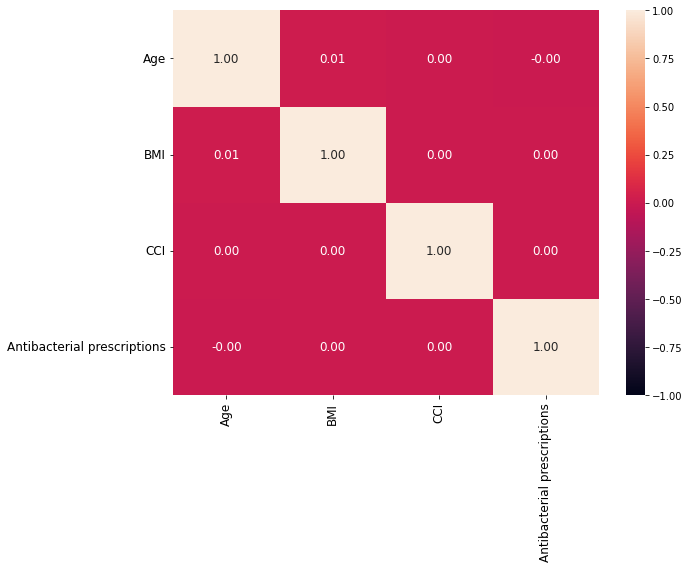

In [84]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data_pneumonia[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_pneumonia/corr_pneumonia.jpg')
plt.show()

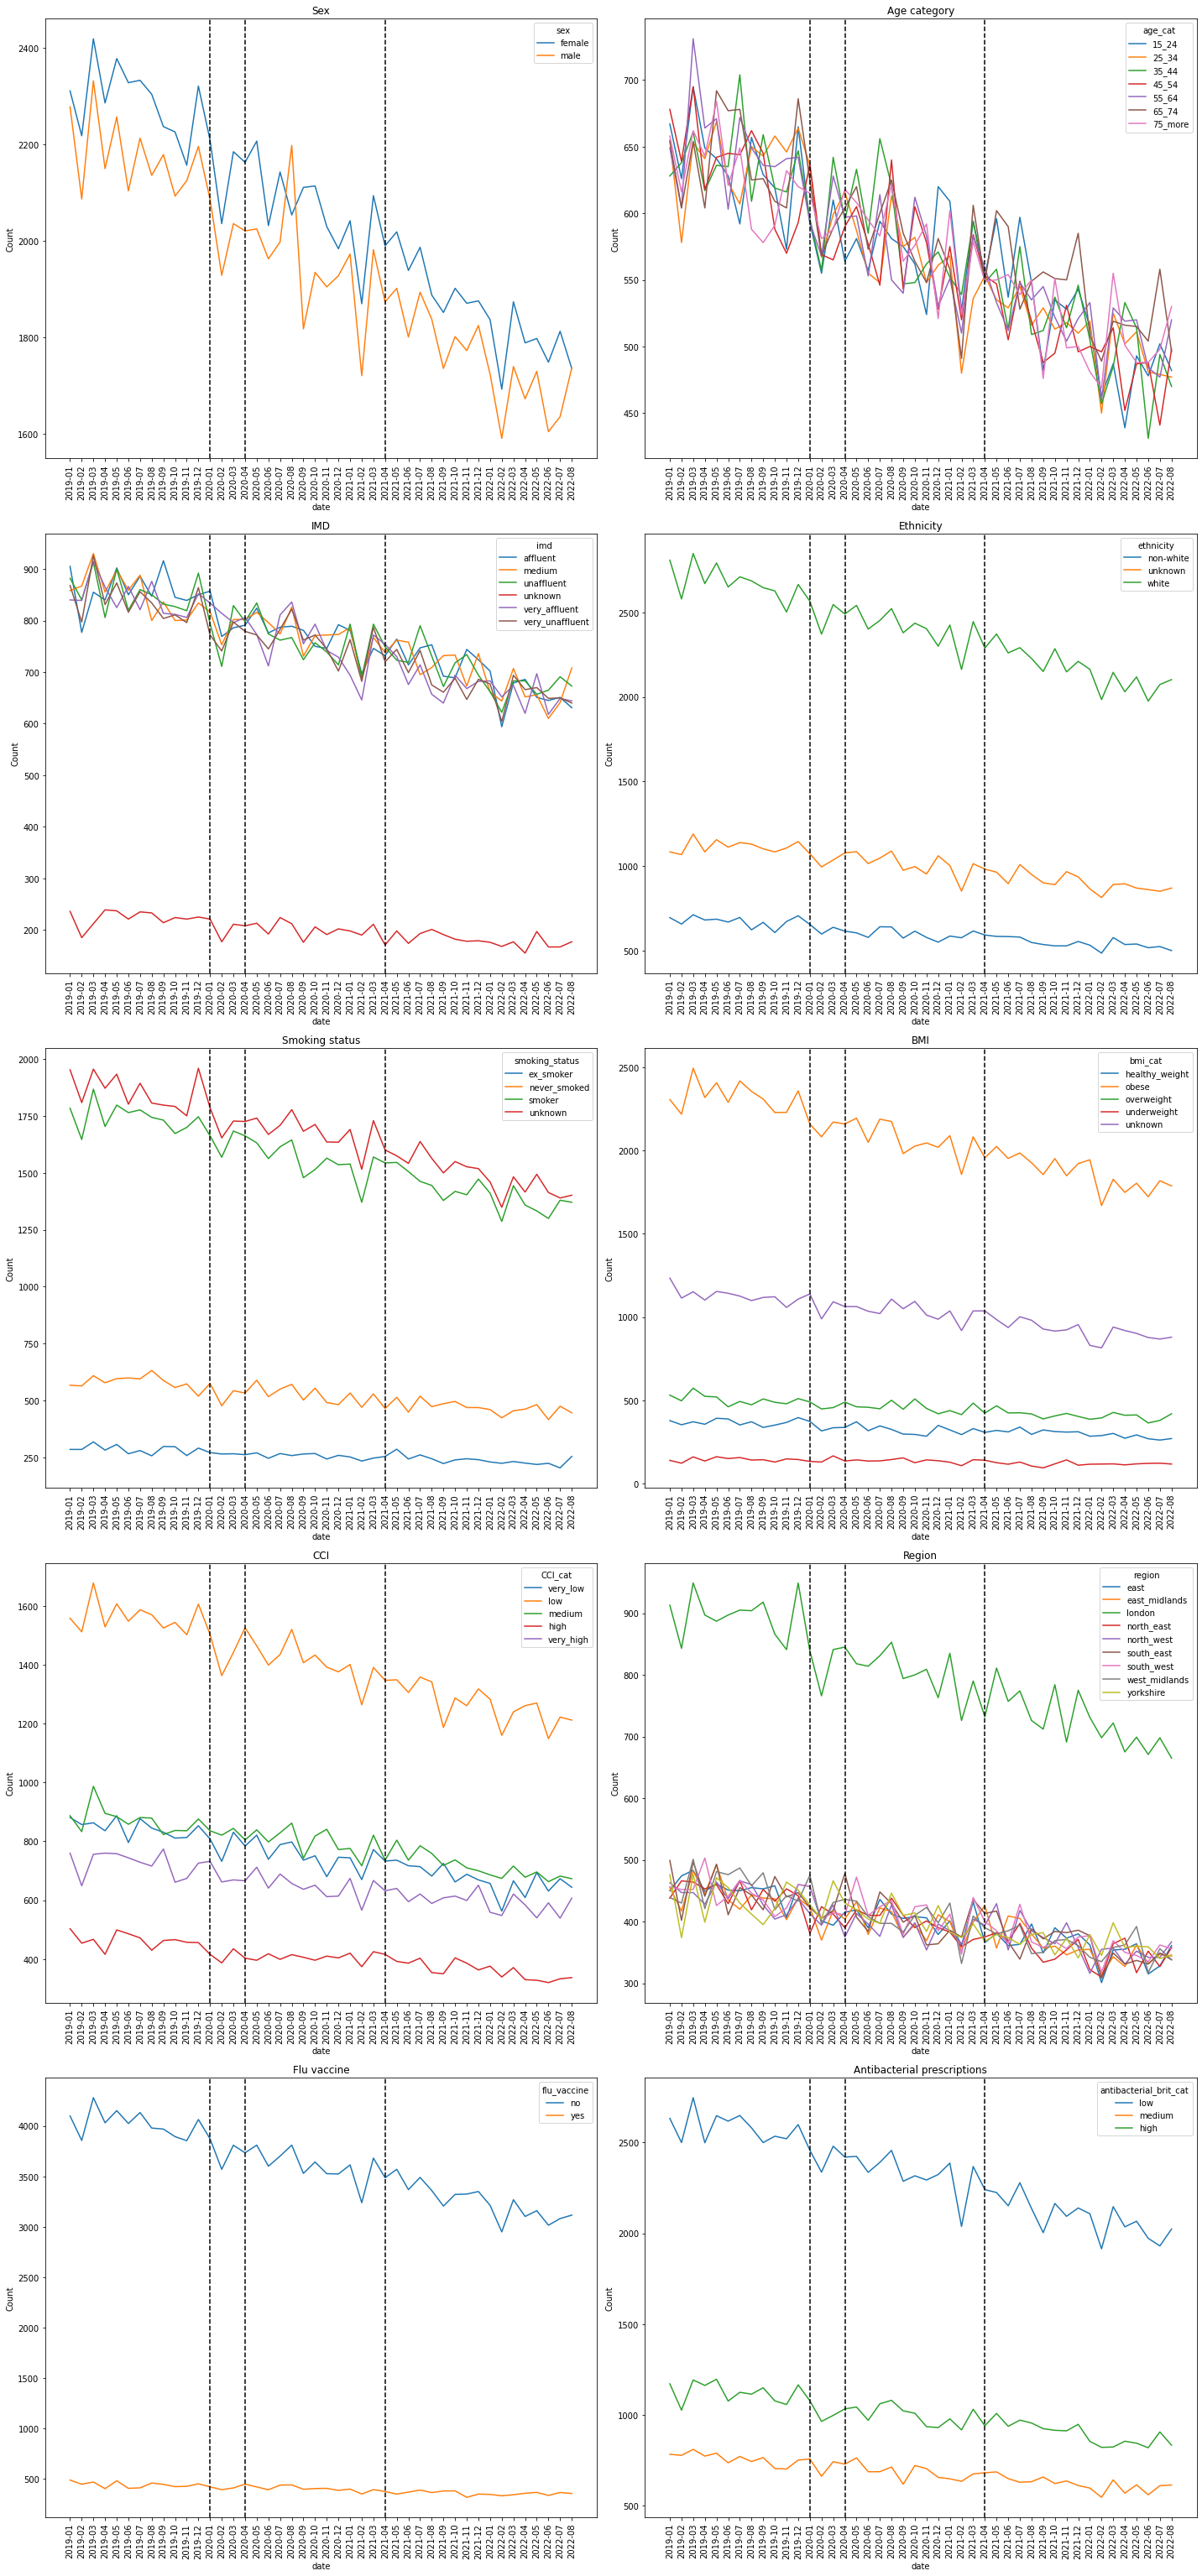

In [85]:
fig, axes = plt.subplots(5,2,
                        figsize=(20, 45)
                        )
create_lineplot(data_pneumonia, 'sex', 'Sex', axes[0,0])
create_lineplot(data_pneumonia, 'age_cat', 'Age category', axes[0,1])
create_lineplot(data_pneumonia, 'imd', 'IMD', axes[1,0])
create_lineplot(data_pneumonia, 'ethnicity', 'Ethnicity', axes[1,1])
create_lineplot(data_pneumonia, 'smoking_status', 'Smoking status', axes[2,0])
create_lineplot(data_pneumonia, 'bmi_cat', 'BMI', axes[2,1])
create_lineplot(data_pneumonia, 'CCI_cat', 'CCI', axes[3,0])
create_lineplot(data_pneumonia, 'region', 'Region', axes[3,1])
create_lineplot(data_pneumonia, 'flu_vaccine', 'Flu vaccine', axes[4,0])
create_lineplot(data_pneumonia, 'antibacterial_brit_cat', 'Antibacterial prescriptions', axes[4,1])
# fig.delaxes(ax=axes[5,1])

# fig.suptitle('Risk Factors of pneumonia patients', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_pneumonia/risk_factors_cat_pneumonia.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics
We separate data of pneumonia to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [86]:
data_pneumonia = data_pneumonia[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                       'antibacterial_brit', 'pneumonia_ab_date', 'ab_type_cat', 'incdt_pneumonia_date', 'date', 'period',
                       'event_pneumonia_admitted', 'duration_pneumonia_admitted'
                        ]]

data_pneumonia.shape

(175954, 18)

In [87]:
#incident and prevalent infection 
data_pneumonia_incdt = data_pneumonia[data_pneumonia['incdt_pneumonia_date'] == 0]
data_pneumonia_prevl = data_pneumonia[data_pneumonia['incdt_pneumonia_date'] == 1]
#switch variable pneumonia_ab_date into a binary variable
data_pneumonia_incdt[['pneumonia_ab_date']] = data_pneumonia_incdt[['pneumonia_ab_date']].where(data_pneumonia_incdt[['pneumonia_ab_date']].isnull(), 1).fillna(0).astype(int)
data_pneumonia_prevl[['pneumonia_ab_date']] = data_pneumonia_prevl[['pneumonia_ab_date']].where(data_pneumonia_prevl[['pneumonia_ab_date']].isnull(), 1).fillna(0).astype(int)

#incident and prevalent infection stratified by sex categories
data_pneumonia_incdt_males = data_pneumonia_incdt[data_pneumonia_incdt['sex'] == 'male']
data_pneumonia_incdt_females = data_pneumonia_incdt[data_pneumonia_incdt['sex'] == 'female']
data_pneumonia_prevl_males = data_pneumonia_prevl[data_pneumonia_prevl['sex'] == 'male']
data_pneumonia_prevl_females = data_pneumonia_prevl[data_pneumonia_prevl['sex'] == 'female']

#incident and prevalent infection stratified by age categories
data_pneumonia_incdt_15_24 = data_pneumonia_incdt[data_pneumonia_incdt['age_cat'] == '15_24']
data_pneumonia_incdt_25_34 = data_pneumonia_incdt[data_pneumonia_incdt['age_cat'] == '25_34']
data_pneumonia_incdt_35_44 = data_pneumonia_incdt[data_pneumonia_incdt['age_cat'] == '35_44']
data_pneumonia_incdt_45_54 = data_pneumonia_incdt[data_pneumonia_incdt['age_cat'] == '45_54']
data_pneumonia_incdt_55_64 = data_pneumonia_incdt[data_pneumonia_incdt['age_cat'] == '55_64']
data_pneumonia_incdt_65_74 = data_pneumonia_incdt[data_pneumonia_incdt['age_cat'] == '65_74']
data_pneumonia_incdt_75_more = data_pneumonia_incdt[data_pneumonia_incdt['age_cat'] == '75_more']
data_pneumonia_prevl_15_24 = data_pneumonia_prevl[data_pneumonia_prevl['age_cat'] == '15_24']
data_pneumonia_prevl_25_34 = data_pneumonia_prevl[data_pneumonia_prevl['age_cat'] == '25_34']
data_pneumonia_prevl_35_44 = data_pneumonia_prevl[data_pneumonia_prevl['age_cat'] == '35_44']
data_pneumonia_prevl_45_54 = data_pneumonia_prevl[data_pneumonia_prevl['age_cat'] == '45_54']
data_pneumonia_prevl_55_64 = data_pneumonia_prevl[data_pneumonia_prevl['age_cat'] == '55_64']
data_pneumonia_prevl_65_74 = data_pneumonia_prevl[data_pneumonia_prevl['age_cat'] == '65_74']
data_pneumonia_prevl_75_more = data_pneumonia_prevl[data_pneumonia_prevl['age_cat'] == '75_more']

data_pneumonia_incdt_prepandemic = data_pneumonia_incdt[data_pneumonia_incdt['date'] <= '2019-12']
data_pneumonia_incdt_during_pandemic = data_pneumonia_incdt[(data_pneumonia_incdt['date'] >= '2020-03') & (data_pneumonia_incdt['date']<= '2021-03')]
data_pneumonia_incdt_post_2nd_lockdown = data_pneumonia_incdt[data_pneumonia_incdt['date'] <= '2021-04']
data_pneumonia_prevl_prepandemic = data_pneumonia_prevl[data_pneumonia_prevl['date'] <= '2019-12']
data_pneumonia_prevl_during_pandemic = data_pneumonia_prevl[(data_pneumonia_prevl['date'] >= '2020-03') & (data_pneumonia_prevl['date']<= '2021-03')]
data_pneumonia_prevl_post_2nd_lockdown = data_pneumonia_prevl[data_pneumonia_prevl['date'] <= '2021-04']

# #incident and prevalent infection stratified by ab categories
# data_pneumonia_incdt_abtype_0 = data_pneumonia_incdt[data_pneumonia_incdt['ab_type_cat'] == data_pneumonia['ab_type_cat'].unique()[0]]
# data_pneumonia_incdt_abtype_1 = data_pneumonia_incdt[data_pneumonia_incdt['ab_type_cat'] == data_pneumonia['ab_type_cat'].unique()[1]]
# data_pneumonia_incdt_abtype_2 = data_pneumonia_incdt[data_pneumonia_incdt['ab_type_cat'] == data_pneumonia['ab_type_cat'].unique()[2]]
# data_pneumonia_incdt_abtype_3 = data_pneumonia_incdt[data_pneumonia_incdt['ab_type_cat'] == data_pneumonia['ab_type_cat'].unique()[3]]
# data_pneumonia_prevl_abtype_0 = data_pneumonia_prevl[data_pneumonia_prevl['ab_type_cat'] == data_pneumonia['ab_type_cat'].unique()[0]]
# data_pneumonia_prevl_abtype_1 = data_pneumonia_prevl[data_pneumonia_prevl['ab_type_cat'] == data_pneumonia['ab_type_cat'].unique()[1]]
# data_pneumonia_prevl_abtype_2 = data_pneumonia_prevl[data_pneumonia_prevl['ab_type_cat'] == data_pneumonia['ab_type_cat'].unique()[2]]
# data_pneumonia_prevl_abtype_3 = data_pneumonia_prevl[data_pneumonia_prevl['ab_type_cat'] == data_pneumonia['ab_type_cat'].unique()[3]]

# #incident and prevalent infection with antibiotics type
# data_pneumonia_incdt_abs = data_pneumonia_incdt[data_pneumonia_incdt['pneumonia_ab_date'] == 1]
# data_pneumonia_prevl_abs = data_pneumonia_prevl[data_pneumonia_prevl['pneumonia_ab_date'] == 1]

# no antibiotics and incident hospital admission
data_pneumonia_no_abs_incdt = data_pneumonia[data_pneumonia['pneumonia_ab_date'].isnull()] #gp_cons_pneumonia_ab
data_pneumonia_no_abs_incdt = data_pneumonia_no_abs_incdt[data_pneumonia_no_abs_incdt['incdt_pneumonia_date'] == 0]

# with antibiotics and incident hospital admission
data_pneumonia_abs_incdt = data_pneumonia[data_pneumonia['pneumonia_ab_date'].notnull()]
data_pneumonia_abs_incdt = data_pneumonia_abs_incdt[data_pneumonia_abs_incdt['incdt_pneumonia_date'] == 0]

# no antibiotics and prevalent hospital admission
data_pneumonia_no_abs_prevl = data_pneumonia[data_pneumonia['pneumonia_ab_date'].isnull()]
data_pneumonia_no_abs_prevl = data_pneumonia_no_abs_prevl[data_pneumonia_no_abs_prevl['incdt_pneumonia_date'] == 1]

# with antibiotics and prevalent hospital admission
data_pneumonia_abs_prevl = data_pneumonia[data_pneumonia['pneumonia_ab_date'].notnull()]
data_pneumonia_abs_prevl = data_pneumonia_abs_prevl[data_pneumonia_abs_prevl['incdt_pneumonia_date'] == 1]

print(f'shape of data_pneumonia_incdt: {data_pneumonia_incdt.shape}')
print(f'shape of data_pneumonia_prevl: {data_pneumonia_prevl.shape}')
print(f'shape of data_pneumonia_no_abs_incdt: {data_pneumonia_no_abs_incdt.shape}')
print(f'shape of data_pneumonia_abs_incdt: {data_pneumonia_abs_incdt.shape}')
print(f'shape of data_pneumonia_no_abs_prevl: {data_pneumonia_no_abs_prevl.shape}')
print(f'shape of data_pneumonia_abs_prevl: {data_pneumonia_abs_prevl.shape}')
print(f'\nvalue counts of data_pneumonia_no_abs_incdt: \n{data_pneumonia_no_abs_incdt.event_pneumonia_admitted.value_counts()}')
print(f'value counts of data_pneumonia_abs_incdt: \n{data_pneumonia_abs_incdt.event_pneumonia_admitted.value_counts()}')
print(f'value counts of data_pneumonia_no_abs_prevl: \n{data_pneumonia_no_abs_prevl.event_pneumonia_admitted.value_counts()}')
print(f'value counts of data_pneumonia_abs_prevl: \n{data_pneumonia_abs_prevl.event_pneumonia_admitted.value_counts()}')

shape of data_pneumonia_incdt: (158429, 18)
shape of data_pneumonia_prevl: (17525, 18)
shape of data_pneumonia_no_abs_incdt: (142360, 18)
shape of data_pneumonia_abs_incdt: (16069, 18)
shape of data_pneumonia_no_abs_prevl: (15781, 18)
shape of data_pneumonia_abs_prevl: (1744, 18)

value counts of data_pneumonia_no_abs_incdt: 
0.0    141354
1.0      1006
Name: event_pneumonia_admitted, dtype: int64
value counts of data_pneumonia_abs_incdt: 
0.0    15956
1.0      113
Name: event_pneumonia_admitted, dtype: int64
value counts of data_pneumonia_no_abs_prevl: 
0.0    15648
1.0      133
Name: event_pneumonia_admitted, dtype: int64
value counts of data_pneumonia_abs_prevl: 
0.0    1731
1.0      13
Name: event_pneumonia_admitted, dtype: int64


In [88]:
#store data for plotting hosp admission counts and percentages
%store data_pneumonia
# save data
data_pneumonia.to_csv('../output/hospitalisation_prediction_pneumonia/data_pneumonia.csv')

Stored 'data_pneumonia' (DataFrame)


## 5- cox modelling for hospital admissions
### 5-1- incident pneumonia with no antibiotics

<lifelines.CoxPHFitter: fitted with 106770 total observations, 106012 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 106770
number of events observed = 758
   partial log-likelihood = -8749.58
         time fit was run = 2022-11-24 01:27:34 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.13       0.88       0.10            -0.33             0.07                 0.72                 1.08
CCI_cat[T.medium]               -0.15       0.86       0.12            -0.38             0.08                 0.68                 1.08
CCI_cat[T.high]                  0.11       1.11       0.13            -0.15             0.37                 0.86                 1.44
CCI_cat[T.very_high]             0.04       1.04       0.12            -0.20             0.27                 0.82                 1.31
age_cat[T.25_34]                -0.01       0.99       0.13            -0.26             0.25                 0.77                 1.28
age_cat[T.35_44]                -0.09       0.91       0.13            -0.35             0.17                 0.70                 1.18
age_cat[T.45_54]                -0.17       0.84       0.14            -0.44             0.10                 0.64                 1.10
age_cat[T.55_64]                -0.04       0.96       0.13            -0.30             0.22                 0.74                 1.24
age_cat[T.65_74]                -0.11       0.89       0.13            -0.37             0.15                 0.69                 1.16
age_cat[T.75_more]              -0.23       0.80       0.14            -0.50             0.04                 0.61                 1.04
antibacterial_brit              -0.00       1.00       0.03            -0.05             0.05                 0.95                 1.05
bmi_cat[T.obese]                 0.00       1.00       0.14            -0.27             0.27                 0.77                 1.31
bmi_cat[T.overweight]            0.17       1.18       0.16            -0.15             0.48                 0.86                 1.62
bmi_cat[T.underweight]          -0.24       0.79       0.26            -0.74             0.26                 0.48                 1.30
bmi_cat[T.unknown]              -0.08       0.92       0.15            -0.37             0.20                 0.69                 1.23
ethnicity[T.unknown]             0.04       1.04       0.12            -0.20             0.28                 0.82                 1.33
ethnicity[T.white]               0.16       1.18       0.11            -0.05             0.38                 0.95                 1.46
flu_vaccine[T.yes]              -0.11       0.90       0.13            -0.35             0.14                 0.70                 1.15
imd[T.medium]                   -0.03       0.97       0.12            -0.26             0.20                 0.77                 1.22
imd[T.unaffluent]               -0.03       0.97       0.12            -0.26             0.19                 0.77                 1.21
imd[T.unknown]                  -0.15       0.86       0.19            -0.53             0.22                 0.59                 1.24
imd[T.very_affluent]             0.07       1.08       0.11            -0.15             0.30                 0.86                 1.34
imd[T.very_unaffluent]          -0.18       0.84       0.12            -0.41             0.06                 0.66                 1.06
region[T.east_midlands]         -0.15       0.86       0.16            -0.46             0.16                 0.63                 1.18
region[T.london]                 0.05       1.05       

12800


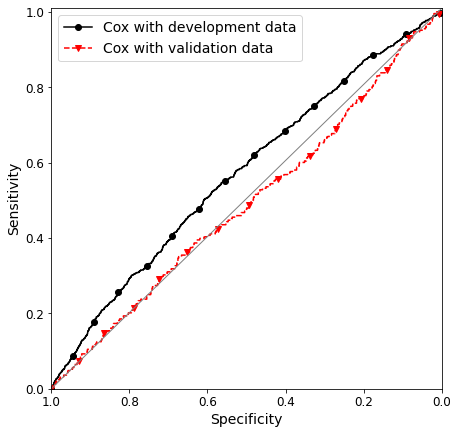

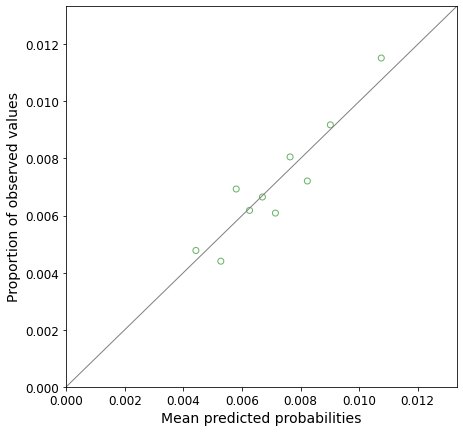

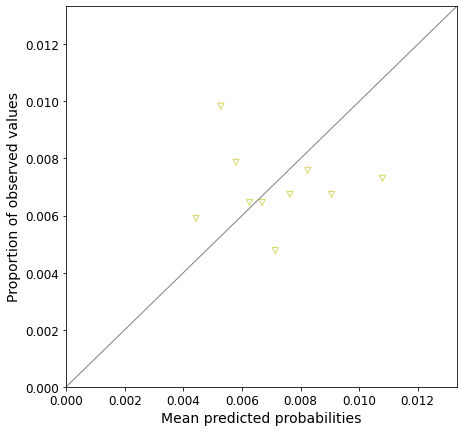

In [89]:
#data prep
data, data_pneumonia_no_abs_incdt_enc = cox_data_prep(data_pneumonia_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

#make summary table
make_summary_table('pneumonia', 'no_abs_incdt', data_pneumonia_no_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('pneumonia', 'no_abs_incdt', data_pneumonia_no_abs_incdt)

try:
    #build cox model 
    cph_pneumonia_no_abs_incdt, data_pneumonia_no_abs_incdt_train, data_pneumonia_no_abs_incdt_test = cox_model_build('pneumonia', 'no_abs_incdt', data_pneumonia_no_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_pneumonia_no_abs_incdt, '../output/hospitalisation_prediction_pneumonia/', 'betas_cph_pneumonia_no_abs_incdt.csv', data_pneumonia_no_abs_incdt_enc, data_pneumonia_no_abs_incdt, 'sum_betas_cph_pneumonia_no_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_pneumonia_no_abs_incdt, 'event_pneumonia_admitted', data_pneumonia_no_abs_incdt_train, data_pneumonia_no_abs_incdt_test, '../output/hospitalisation_prediction_pneumonia', 'roc_cph_pneumonia_no_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_pneumonia_no_abs_incdt, data_pneumonia_no_abs_incdt_train, 'event_pneumonia_admitted', data_pneumonia_no_abs_incdt_test, '../output/hospitalisation_prediction_pneumonia/', 'calibration_cph_pneumonia_no_abs_incdt_train.jpg', 'calibration_cph_pneumonia_no_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_pneumonia_no_abs_incdt, 'pneumonia', 'no_abs_incdt', data_pneumonia_no_abs_incdt_train, data_pneumonia_no_abs_incdt_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-2- incident pneumonia with antibiotics

<lifelines.CoxPHFitter: fitted with 12051 total observations, 11965 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 12051
number of events observed = 86
   partial log-likelihood = -785.62
         time fit was run = 2022-11-24 01:27:58 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.11       1.12       0.32            -0.51             0.73                 0.60                 2.08
CCI_cat[T.medium]                0.01       1.01       0.36            -0.69             0.72                 0.50                 2.05
CCI_cat[T.high]                 -0.43       0.65       0.52            -1.44             0.59                 0.24                 1.80
CCI_cat[T.very_high]             0.48       1.62       0.34            -0.19             1.15                 0.83                 3.17
age_cat[T.25_34]                -0.61       0.55       0.42            -1.42             0.21                 0.24                 1.24
age_cat[T.35_44]                -0.71       0.49       0.43            -1.56             0.14                 0.21                 1.15
age_cat[T.45_54]                -0.56       0.57       0.42            -1.38             0.25                 0.25                 1.29
age_cat[T.55_64]                -0.75       0.47       0.43            -1.60             0.10                 0.20                 1.11
age_cat[T.65_74]                 0.09       1.10       0.34            -0.57             0.76                 0.56                 2.14
age_cat[T.75_more]               0.05       1.05       0.35            -0.63             0.74                 0.53                 2.09
antibacterial_brit               0.12       1.13       0.07            -0.02             0.27                 0.98                 1.30
bmi_cat[T.obese]                 0.68       1.97       0.52            -0.34             1.70                 0.71                 5.47
bmi_cat[T.overweight]            0.17       1.19       0.65            -1.09             1.44                 0.34                 4.22
bmi_cat[T.underweight]          -0.47       0.62       1.12            -2.66             1.72                 0.07                 5.60
bmi_cat[T.unknown]               0.74       2.09       0.54            -0.32             1.79                 0.73                 5.99
ethnicity[T.unknown]            -0.34       0.71       0.34            -1.00             0.32                 0.37                 1.37
ethnicity[T.white]              -0.27       0.76       0.29            -0.84             0.29                 0.43                 1.34
flu_vaccine[T.yes]               0.28       1.33       0.32            -0.35             0.92                 0.71                 2.50
imd[T.medium]                   -0.26       0.77       0.39            -1.02             0.50                 0.36                 1.65
imd[T.unaffluent]               -0.05       0.95       0.37            -0.78             0.67                 0.46                 1.96
imd[T.unknown]                  -0.66       0.52       0.75            -2.14             0.82                 0.12                 2.26
imd[T.very_affluent]             0.42       1.53       0.34            -0.23             1.08                 0.79                 2.95
imd[T.very_unaffluent]           0.36       1.44       0.34            -0.30             1.03                 0.74                 2.79
region[T.east_midlands]         -0.72       0.48       0.50            -1.71             0.26                 0.18                 1.29
region[T.london]                -0.91       0.40       0.43 

12779


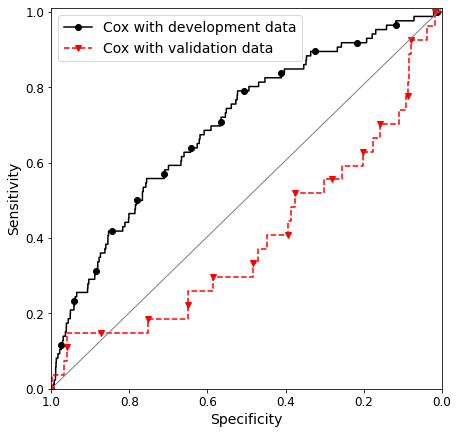

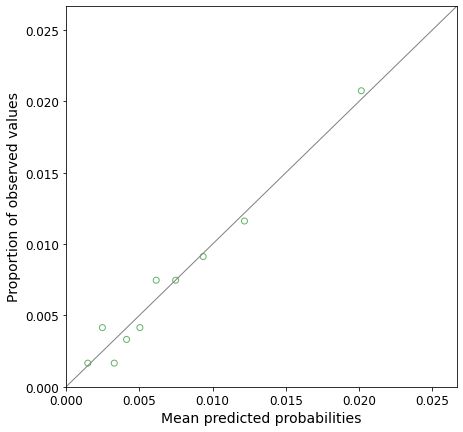

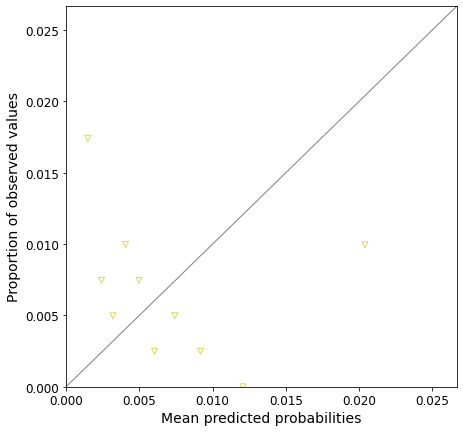

In [90]:
#data prep
data, data_pneumonia_abs_incdt_enc = cox_data_prep(data_pneumonia_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

#make summary table
make_summary_table('pneumonia', 'abs_incdt', data_pneumonia_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('pneumonia', 'abs_incdt', data_pneumonia_abs_incdt)

try:
    #build cox model 
    cph_pneumonia_abs_incdt, data_pneumonia_abs_incdt_train, data_pneumonia_abs_incdt_test = cox_model_build('pneumonia', 'abs_incdt', data_pneumonia_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_pneumonia_abs_incdt, '../output/hospitalisation_prediction_pneumonia/', 'betas_cph_pneumonia_abs_incdt.csv', data_pneumonia_abs_incdt_enc, data_pneumonia_abs_incdt, 'sum_betas_cph_pneumonia_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_pneumonia_abs_incdt, 'event_pneumonia_admitted', data_pneumonia_abs_incdt_train, data_pneumonia_abs_incdt_test, '../output/hospitalisation_prediction_pneumonia', 'roc_cph_pneumonia_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_pneumonia_abs_incdt, data_pneumonia_abs_incdt_train, 'event_pneumonia_admitted', data_pneumonia_abs_incdt_test, '../output/hospitalisation_prediction_pneumonia/', 'calibration_cph_pneumonia_abs_incdt_train.jpg', 'calibration_cph_pneumonia_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_pneumonia_abs_incdt, 'pneumonia', 'abs_incdt', data_pneumonia_abs_incdt_train, data_pneumonia_abs_incdt_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-3- prevalent pneumonia with no antibiotics

<lifelines.CoxPHFitter: fitted with 11835 total observations, 11737 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 11835
number of events observed = 98
   partial log-likelihood = -899.93
         time fit was run = 2022-11-24 01:28:04 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.21       0.81       0.27            -0.74             0.31                 0.48                 1.37
CCI_cat[T.medium]               -0.56       0.57       0.34            -1.22             0.10                 0.30                 1.11
CCI_cat[T.high]                 -0.39       0.68       0.39            -1.16             0.38                 0.31                 1.46
CCI_cat[T.very_high]            -0.22       0.80       0.32            -0.84             0.40                 0.43                 1.49
age_cat[T.25_34]                 0.05       1.05       0.41            -0.75             0.85                 0.47                 2.34
age_cat[T.35_44]                 0.40       1.48       0.37            -0.34             1.13                 0.71                 3.09
age_cat[T.45_54]                 0.19       1.21       0.39            -0.58             0.96                 0.56                 2.61
age_cat[T.55_64]                -0.03       0.97       0.41            -0.83             0.77                 0.43                 2.16
age_cat[T.65_74]                 0.34       1.41       0.38            -0.40             1.08                 0.67                 2.95
age_cat[T.75_more]               0.05       1.05       0.40            -0.73             0.84                 0.48                 2.31
antibacterial_brit              -0.13       0.87       0.08            -0.28             0.01                 0.75                 1.02
bmi_cat[T.obese]                 0.38       1.46       0.43            -0.47             1.22                 0.63                 3.39
bmi_cat[T.overweight]            0.67       1.96       0.48            -0.27             1.61                 0.77                 5.02
bmi_cat[T.underweight]           0.19       1.21       0.71            -1.20             1.58                 0.30                 4.87
bmi_cat[T.unknown]              -0.04       0.96       0.47            -0.96             0.89                 0.38                 2.43
ethnicity[T.unknown]            -0.22       0.80       0.33            -0.86             0.43                 0.42                 1.53
ethnicity[T.white]              -0.04       0.96       0.28            -0.59             0.51                 0.55                 1.67
flu_vaccine[T.yes]              -0.42       0.66       0.42            -1.24             0.41                 0.29                 1.51
imd[T.medium]                    0.01       1.01       0.32            -0.63             0.65                 0.53                 1.91
imd[T.unaffluent]                0.38       1.46       0.30            -0.21             0.97                 0.81                 2.64
imd[T.unknown]                   0.04       1.04       0.50            -0.95             1.03                 0.39                 2.79
imd[T.very_affluent]            -0.16       0.85       0.34            -0.83             0.50                 0.44                 1.65
imd[T.very_unaffluent]          -0.45       0.64       0.37            -1.18             0.27                 0.31                 1.31
region[T.east_midlands]         -0.02       0.98       0.42            -0.84             0.80                 0.43                 2.23
region[T.london]                -0.46       0.63       0.39 

12780


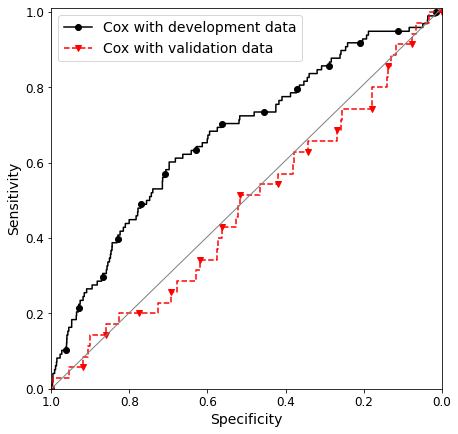

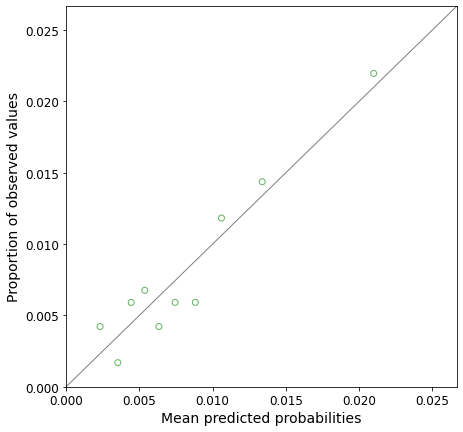

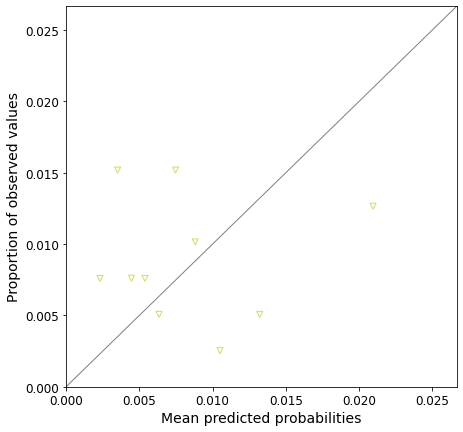

In [91]:
#data prep
data, data_pneumonia_no_abs_prevl_enc = cox_data_prep(data_pneumonia_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

#make summary table
make_summary_table('pneumonia', 'no_abs_prevl', data_pneumonia_no_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('pneumonia', 'no_abs_prevl', data_pneumonia_no_abs_prevl)

try:
    #build cox model 
    cph_pneumonia_no_abs_prevl, data_pneumonia_no_abs_prevl_train, data_pneumonia_no_abs_prevl_test = cox_model_build('pneumonia', 'no_abs_prevl', data_pneumonia_no_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:    
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_pneumonia_no_abs_prevl, '../output/hospitalisation_prediction_pneumonia/', 'betas_cph_pneumonia_no_abs_prevl.csv', data_pneumonia_no_abs_prevl_enc, data_pneumonia_no_abs_prevl, 'sum_betas_cph_pneumonia_no_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_pneumonia_no_abs_prevl, 'event_pneumonia_admitted', data_pneumonia_no_abs_prevl_train, data_pneumonia_no_abs_prevl_test, '../output/hospitalisation_prediction_pneumonia', 'roc_cph_pneumonia_no_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_pneumonia_no_abs_prevl, data_pneumonia_no_abs_prevl_train, 'event_pneumonia_admitted', data_pneumonia_no_abs_prevl_test, '../output/hospitalisation_prediction_pneumonia/', 'calibration_cph_pneumonia_no_abs_prevl_train.jpg', 'calibration_cph_pneumonia_no_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_pneumonia_no_abs_prevl, 'pneumonia', 'no_abs_prevl', data_pneumonia_no_abs_prevl_train, data_pneumonia_no_abs_prevl_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-4- prevalent pneumonia with antibiotics

<lifelines.CoxPHFitter: fitted with 1308 total observations, 1297 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 1308
number of events observed = 11
   partial log-likelihood = -51.89
         time fit was run = 2022-11-24 01:28:10 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  18.54   1.12e+08    6008.95        -11758.79         11795.86                 0.00                  inf
CCI_cat[T.medium]               19.23   2.24e+08    6008.95        -11758.10         11796.55                 0.00                  inf
CCI_cat[T.high]                 20.02   4.95e+08    6008.95        -11757.30         11797.34                 0.00                  inf
CCI_cat[T.very_high]            18.99   1.77e+08    6008.95        -11758.33         11796.31                 0.00                  inf
age_cat[T.25_34]               -17.90       0.00    7077.14        -13888.83         13853.04                 0.00                  inf
age_cat[T.35_44]                -0.17       0.84       1.34            -2.81             2.46                 0.06                11.72
age_cat[T.45_54]                -0.54       0.58       1.37            -3.23             2.15                 0.04                 8.55
age_cat[T.55_64]                 1.62       5.05       1.13            -0.59             3.83                 0.56                45.90
age_cat[T.65_74]                 0.45       1.56       1.11            -1.72             2.62                 0.18                13.70
age_cat[T.75_more]               0.44       1.55       1.14            -1.80             2.68                 0.16                14.54
antibacterial_brit              -0.67       0.51       0.36            -1.37             0.03                 0.25                 1.03
bmi_cat[T.obese]                19.00   1.78e+08   11290.16        -22109.32         22147.31                 0.00                  inf
bmi_cat[T.overweight]           -0.08       0.92   13401.56        -26266.65         26266.48                 0.00                  inf
bmi_cat[T.underweight]          20.81   1.09e+09   11290.16        -22107.51         22149.12                 0.00                  inf
bmi_cat[T.unknown]              18.78   1.43e+08   11290.16        -22109.53         22147.10                 0.00                  inf
ethnicity[T.unknown]             2.51      12.32       1.86            -1.13             6.16                 0.32               471.78
ethnicity[T.white]               2.09       8.08       1.54            -0.93             5.11                 0.40               164.89
flu_vaccine[T.yes]             -17.46       0.00    9025.83        -17707.76         17672.83                 0.00                  inf
imd[T.medium]                    0.30       1.34       1.10            -1.86             2.46                 0.16                11.66
imd[T.unaffluent]              -18.17       0.00    6448.65        -12657.30         12620.97                 0.00                  inf
imd[T.unknown]                 -19.17       0.00   12032.34        -23602.13         23563.78                 0.00                  inf
imd[T.very_affluent]             0.13       1.14       1.06            -1.94             2.20                 0.14                 9.06
imd[T.very_unaffluent]           0.99       2.70       0.93            -0.83             2.82                 0.43                16.83
region[T.east_midlands]        -19.92       0.00    8603.25        -16881.99         16842.15                 0.00                  inf
region[T.london]               -19.07       0.00    6944.56     

12988


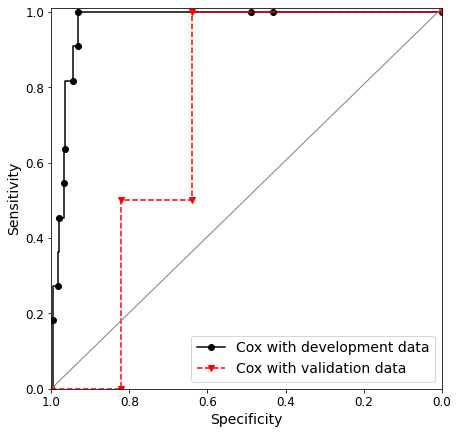

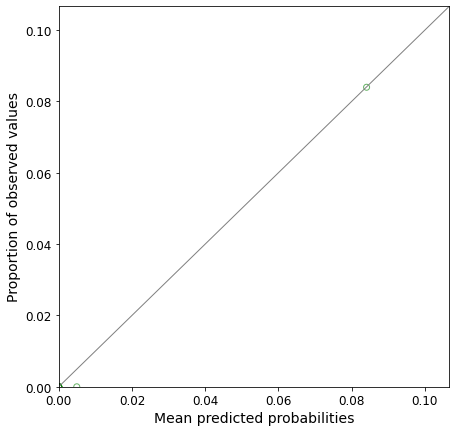

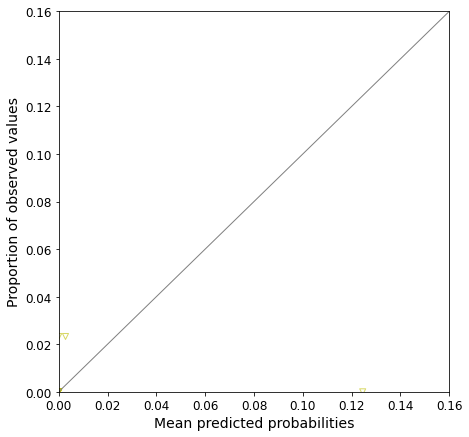

In [92]:
#data prep
data, data_pneumonia_abs_prevl_enc = cox_data_prep(data_pneumonia_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

#make summary table
make_summary_table('pneumonia', 'abs_prevl', data_pneumonia_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('pneumonia', 'abs_prevl', data_pneumonia_abs_prevl)

try:
    #build cox model 
    cph_pneumonia_abs_prevl, data_pneumonia_abs_prevl_train, data_pneumonia_abs_prevl_test = cox_model_build('pneumonia', 'abs_prevl', data_pneumonia_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_pneumonia_abs_prevl, '../output/hospitalisation_prediction_pneumonia/', 'betas_cph_pneumonia_abs_prevl.csv', data_pneumonia_abs_prevl_enc, data_pneumonia_abs_prevl, 'sum_betas_cph_pneumonia_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_pneumonia_abs_prevl, 'event_pneumonia_admitted', data_pneumonia_abs_prevl_train, data_pneumonia_abs_prevl_test, '../output/hospitalisation_prediction_pneumonia', 'roc_cph_pneumonia_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_pneumonia_abs_prevl, data_pneumonia_abs_prevl_train, 'event_pneumonia_admitted', data_pneumonia_abs_prevl_test, '../output/hospitalisation_prediction_pneumonia/', 'calibration_cph_pneumonia_abs_prevl_train.jpg', 'calibration_cph_pneumonia_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_pneumonia_abs_prevl, 'pneumonia', 'abs_prevl', data_pneumonia_abs_prevl_train, data_pneumonia_abs_prevl_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-5- incident pneumonia

In [93]:
#data prep
data, data_pneumonia_incdt_enc = cox_data_prep(data_pneumonia_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

#make summary tables from preped data
make_summary_table('pneumonia', 'incdt', data_pneumonia_incdt_enc)
make_summary_table_hosped('pneumonia', 'incdt', data_pneumonia_incdt)

try:
    cph_pneumonia_incdt, data_pneumonia_incdt_train, data_pneumonia_incdt_test = cox_model_abs_build('pneumonia', 'incdt', data_pneumonia_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_pneumonia_incdt, 'pneumonia', 'incdt', data_pneumonia_incdt_train, data_pneumonia_incdt_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 118821 total observations, 117962 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 118821
number of events observed = 859
   partial log-likelihood = -10013.41
         time fit was run = 2022-11-24 01:28:18 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.05       0.95       0.10            -0.24             0.14                 0.79                 1.15
CCI_cat[T.medium]               -0.14       0.87       0.11            -0.36             0.09                 0.70                 1.09
CCI_cat[T.high]                  0.07       1.08       0.13            -0.18             0.32                 0.84                 1.38
CCI_cat[T.very_high]             0.10       1.11       0.11            -0.12             0.32                 0.89                 1.38
age_cat[T.25_34]                -0.03       0.98       0.13            -0.27             0.22                 0.76                 1.25
age_cat[T.35_44]                -0.14       0.87       0.13            -0.40             0.11                 0.67                 1.12
age_cat[T.45_54]                -0.11       0.89       0.13            -0.36             0.14                 0.69                 1.15
age_cat[T.55_64]                 0.02       1.02       0.12            -0.23             0.26                 0.80                 1.30
age_cat[T.65_74]                -0.00       1.00       0.12            -0.24             0.24                 0.78                 1.28
age_cat[T.75_more]              -0.08       0.93       0.13            -0.33             0.17                 0.72                 1.19
antibacterial_brit               0.01       1.01       0.02            -0.04             0.06                 0.96                 1.06
bmi_cat[T.obese]                 0.06       1.06       0.13            -0.19             0.32                 0.82                 1.37
bmi_cat[T.overweight]            0.11       1.12       0.16            -0.20             0.41                 0.82                 1.51
bmi_cat[T.underweight]          -0.26       0.77       0.25            -0.75             0.23                 0.47                 1.26
bmi_cat[T.unknown]              -0.03       0.97       0.14            -0.30             0.25                 0.74                 1.28
ethnicity[T.unknown]            -0.02       0.98       0.12            -0.24             0.21                 0.78                 1.23
ethnicity[T.white]               0.11       1.11       0.10            -0.09             0.30                 0.91                 1.35
flu_vaccine[T.yes]               0.03       1.03       0.11            -0.19             0.25                 0.83                 1.28
imd[T.medium]                   -0.04       0.96       0.11            -0.25             0.18                 0.78                 1.19
imd[T.unaffluent]               -0.06       0.94       0.11            -0.28             0.16                 0.76                 1.17
imd[T.unknown]                  -0.12       0.89       0.18            -0.47             0.23                 0.63                 1.26
imd[T.very_affluent]             0.01       1.01       0.11            -0.20             0.23                 0.82                 1.25
imd[T.very_unaffluent]          -0.00       1.00       0.11            -0.22             0.21                 0.80                 1.23
pneumonia_ab_date                0.04       1.04       0.11            -0.17             0.26                 0.84                 1.30
region[T.east_midlands]         -0.30       0.74      

13064


### 5-6- hospital admission related to prevalent pneumonia

In [94]:
#data prep
data, data_pneumonia_prevl_enc = cox_data_prep(data_pneumonia_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

#make summary tables from preped data
make_summary_table('pneumonia', 'prevl', data_pneumonia_prevl_enc)
make_summary_table_hosped('pneumonia', 'prevl', data_pneumonia_prevl)

try:
    cph_pneumonia_prevl, data_pneumonia_prevl_train, data_pneumonia_prevl_test = cox_model_abs_build('pneumonia', 'prevl', data_pneumonia_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_pneumonia_prevl, 'pneumonia', 'prevl', data_pneumonia_prevl_train, data_pneumonia_prevl_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13143 total observations, 13032 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 13143
number of events observed = 111
   partial log-likelihood = -1032.70
         time fit was run = 2022-11-24 01:28:27 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.11       0.89       0.26            -0.62             0.39                 0.54                 1.48
CCI_cat[T.medium]               -0.29       0.75       0.31            -0.89             0.31                 0.41                 1.36
CCI_cat[T.high]                 -0.51       0.60       0.41            -1.31             0.28                 0.27                 1.33
CCI_cat[T.very_high]            -0.11       0.89       0.30            -0.70             0.48                 0.50                 1.61
age_cat[T.25_34]                 0.15       1.17       0.36            -0.55             0.86                 0.58                 2.36
age_cat[T.35_44]                 0.20       1.22       0.35            -0.50             0.89                 0.61                 2.44
age_cat[T.45_54]                 0.01       1.01       0.37            -0.72             0.74                 0.49                 2.10
age_cat[T.55_64]                -0.10       0.91       0.38            -0.84             0.65                 0.43                 1.91
age_cat[T.65_74]                 0.44       1.56       0.34            -0.21             1.10                 0.81                 3.01
age_cat[T.75_more]              -0.01       0.99       0.37            -0.73             0.72                 0.48                 2.06
antibacterial_brit              -0.16       0.86       0.07            -0.30            -0.01                 0.74                 0.99
bmi_cat[T.obese]                 0.63       1.88       0.47            -0.28             1.54                 0.75                 4.68
bmi_cat[T.overweight]            0.75       2.12       0.52            -0.26             1.77                 0.77                 5.84
bmi_cat[T.underweight]           0.86       2.37       0.63            -0.38             2.11                 0.68                 8.23
bmi_cat[T.unknown]               0.52       1.68       0.49            -0.44             1.47                 0.65                 4.37
ethnicity[T.unknown]            -0.54       0.58       0.31            -1.14             0.07                 0.32                 1.07
ethnicity[T.white]              -0.18       0.83       0.25            -0.67             0.31                 0.51                 1.36
flu_vaccine[T.yes]              -0.38       0.68       0.39            -1.15             0.38                 0.32                 1.47
imd[T.medium]                   -0.21       0.81       0.33            -0.85             0.43                 0.43                 1.54
imd[T.unaffluent]                0.28       1.32       0.29            -0.29             0.85                 0.75                 2.34
imd[T.unknown]                   0.28       1.32       0.44            -0.58             1.13                 0.56                 3.10
imd[T.very_affluent]            -0.02       0.98       0.31            -0.63             0.59                 0.53                 1.81
imd[T.very_unaffluent]          -0.09       0.92       0.32            -0.71             0.53                 0.49                 1.71
pneumonia_ab_date               -0.15       0.86       0.33            -0.80             0.50                 0.45                 1.66
region[T.east_midlands]         -0.35       0.70       0.3

13069


### 5-7- hospital admission related to incident pneumonia with prescribed antibiotics categories

In [95]:
#data prep
data, data_pneumonia_incdt_abs_enc = cox_data_prep(data_pneumonia_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_incdt_abs, data_pneumonia_incdt_abs_train, data_pneumonia_incdt_abs_test = cox_model_ab_type_build('pneumonia', 'incdt_ab_type', data_pneumonia_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_pneumonia_incdt_abs, 'pneumonia', 'incdt_abs', data_pneumonia_incdt_abs_train, data_pneumonia_incdt_abs_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 118821 total observations, 117962 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 118821
number of events observed = 859
   partial log-likelihood = -10011.94
         time fit was run = 2022-11-24 01:28:31 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.05       0.95       0.10            -0.24             0.14                 0.79                 1.15
CCI_cat[T.medium]               -0.14       0.87       0.11            -0.36             0.08                 0.70                 1.09
CCI_cat[T.high]                  0.07       1.07       0.13            -0.18             0.32                 0.83                 1.38
CCI_cat[T.very_high]             0.10       1.11       0.11            -0.12             0.32                 0.89                 1.38
ab_type_cat[T.Doxycycline]       1.12       3.06       1.00            -0.84             3.08                 0.43                21.71
ab_type_cat[T.no]                0.94       2.57       0.71            -0.44             2.33                 0.64                10.29
ab_type_cat[T.other]             1.02       2.78       0.72            -0.38             2.42                 0.68                11.30
age_cat[T.25_34]                -0.03       0.97       0.13            -0.27             0.22                 0.76                 1.25
age_cat[T.35_44]                -0.14       0.87       0.13            -0.40             0.11                 0.67                 1.12
age_cat[T.45_54]                -0.11       0.89       0.13            -0.36             0.14                 0.69                 1.15
age_cat[T.55_64]                 0.02       1.02       0.12            -0.23             0.26                 0.80                 1.30
age_cat[T.65_74]                -0.00       1.00       0.12            -0.25             0.24                 0.78                 1.28
age_cat[T.75_more]              -0.08       0.93       0.13            -0.33             0.17                 0.72                 1.19
antibacterial_brit               0.01       1.01       0.02            -0.04             0.06                 0.96                 1.06
bmi_cat[T.obese]                 0.06       1.06       0.13            -0.19             0.32                 0.82                 1.37
bmi_cat[T.overweight]            0.11       1.12       0.16            -0.20             0.41                 0.82                 1.51
bmi_cat[T.underweight]          -0.26       0.77       0.25            -0.75             0.23                 0.47                 1.26
bmi_cat[T.unknown]              -0.03       0.97       0.14            -0.30             0.25                 0.74                 1.28
ethnicity[T.unknown]            -0.02       0.98       0.12            -0.24             0.21                 0.78                 1.23
ethnicity[T.white]               0.11       1.11       0.10            -0.09             0.30                 0.91                 1.35
flu_vaccine[T.yes]               0.03       1.03       0.11            -0.19             0.25                 0.83                 1.28
imd[T.medium]                   -0.04       0.96       0.11            -0.25             0.18                 0.78                 1.19
imd[T.unaffluent]               -0.06       0.94       0.11            -0.28             0.16                 0.76                 1.17
imd[T.unknown]                  -0.12       0.89       0.18            -0.47             0.23                 0.63                 1.26
imd[T.very_affluent]             0.01       1.01      

13625


### 5-8- hospital admission related to prevalent pneumonia with prescribed antibiotics categories

In [96]:
#data prep
data, data_pneumonia_prevl_abs_enc = cox_data_prep(data_pneumonia_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_prevl_abs, data_pneumonia_prevl_abs_train, data_pneumonia_prevl_abs_test = cox_model_ab_type_build('pneumonia', 'prevl_ab_type', data_pneumonia_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_pneumonia_prevl_abs, 'pneumonia', 'prevl_abs', data_pneumonia_prevl_abs_train, data_pneumonia_prevl_abs_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13143 total observations, 13032 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 13143
number of events observed = 111
   partial log-likelihood = -1031.81
         time fit was run = 2022-11-24 01:28:37 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.11       0.90       0.26            -0.61             0.40                 0.54                 1.49
CCI_cat[T.medium]               -0.29       0.75       0.31            -0.89             0.31                 0.41                 1.36
CCI_cat[T.high]                 -0.51       0.60       0.41            -1.31             0.29                 0.27                 1.34
CCI_cat[T.very_high]            -0.11       0.90       0.30            -0.70             0.48                 0.50                 1.62
ab_type_cat[T.Doxycycline]       0.15       1.16    3782.74         -7413.88          7414.17                 0.00                  inf
ab_type_cat[T.no]               14.86   2.83e+06    1934.92         -3777.52          3807.23                 0.00                  inf
ab_type_cat[T.other]            14.80   2.67e+06    1934.92         -3777.58          3807.18                 0.00                  inf
age_cat[T.25_34]                 0.16       1.17       0.36            -0.55             0.86                 0.58                 2.37
age_cat[T.35_44]                 0.20       1.22       0.35            -0.50             0.90                 0.61                 2.45
age_cat[T.45_54]                 0.01       1.01       0.37            -0.71             0.74                 0.49                 2.10
age_cat[T.55_64]                -0.09       0.91       0.38            -0.84             0.65                 0.43                 1.92
age_cat[T.65_74]                 0.45       1.56       0.34            -0.21             1.10                 0.81                 3.01
age_cat[T.75_more]              -0.00       1.00       0.37            -0.73             0.73                 0.48                 2.07
antibacterial_brit              -0.16       0.86       0.07            -0.30            -0.01                 0.74                 0.99
bmi_cat[T.obese]                 0.63       1.88       0.47            -0.28             1.55                 0.76                 4.70
bmi_cat[T.overweight]            0.75       2.13       0.52            -0.26             1.77                 0.77                 5.86
bmi_cat[T.underweight]           0.86       2.37       0.63            -0.38             2.11                 0.68                 8.23
bmi_cat[T.unknown]               0.52       1.68       0.49            -0.43             1.48                 0.65                 4.38
ethnicity[T.unknown]            -0.54       0.58       0.31            -1.15             0.07                 0.32                 1.07
ethnicity[T.white]              -0.18       0.83       0.25            -0.67             0.31                 0.51                 1.36
flu_vaccine[T.yes]              -0.38       0.68       0.39            -1.15             0.39                 0.32                 1.47
imd[T.medium]                   -0.21       0.81       0.33            -0.85             0.43                 0.43                 1.54
imd[T.unaffluent]                0.28       1.32       0.29            -0.29             0.85                 0.74                 2.34
imd[T.unknown]                   0.28       1.32       0.44            -0.58             1.14                 0.56                 3.12
imd[T.very_affluent]            -0.02       0.98       0.3

13659


### 5-9- stratified by sex
#### 5-9-1- incident males

In [97]:
#data prep
data, data_pneumonia_incdt_males_enc = cox_data_prep(data_pneumonia_incdt_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_incdt_males, data_pneumonia_incdt_males_train, data_pneumonia_incdt_males_test = cox_model_strat_sex_build('pneumonia', 'incdt_males', data_pneumonia_incdt_males)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_pneumonia_incdt_males, 'pneumonia', 'incdt_males', data_pneumonia_incdt_males_train, data_pneumonia_incdt_males_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 57758 total observations, 57352 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 57758
number of events observed = 406
   partial log-likelihood = -4417.23
         time fit was run = 2022-11-24 01:28:39 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.12       0.89       0.14            -0.40             0.16                 0.67                 1.17
CCI_cat[T.medium]               -0.27       0.76       0.17            -0.60             0.06                 0.55                 1.06
CCI_cat[T.high]                  0.17       1.19       0.18            -0.18             0.52                 0.83                 1.69
CCI_cat[T.very_high]             0.18       1.20       0.16            -0.13             0.49                 0.88                 1.63
age_cat[T.25_34]                -0.17       0.85       0.17            -0.51             0.17                 0.60                 1.19
age_cat[T.35_44]                -0.17       0.85       0.17            -0.51             0.17                 0.60                 1.19
age_cat[T.45_54]                -0.52       0.59       0.19            -0.90            -0.14                 0.41                 0.87
age_cat[T.55_64]                -0.29       0.75       0.18            -0.64             0.07                 0.53                 1.07
age_cat[T.65_74]                -0.32       0.73       0.18            -0.67             0.03                 0.51                 1.03
age_cat[T.75_more]              -0.21       0.81       0.18            -0.56             0.13                 0.57                 1.14
antibacterial_brit               0.04       1.04       0.03            -0.03             0.11                 0.97                 1.12
bmi_cat[T.obese]                 0.13       1.14       0.21            -0.27             0.53                 0.76                 1.71
bmi_cat[T.overweight]            0.56       1.75       0.23             0.11             1.01                 1.12                 2.74
bmi_cat[T.underweight]          -0.02       0.98       0.36            -0.72             0.68                 0.49                 1.98
bmi_cat[T.unknown]               0.17       1.19       0.22            -0.25             0.60                 0.78                 1.82
ethnicity[T.unknown]            -0.05       0.95       0.17            -0.38             0.28                 0.68                 1.32
ethnicity[T.white]               0.13       1.14       0.15            -0.15             0.42                 0.86                 1.52
flu_vaccine[T.yes]               0.01       1.01       0.16            -0.31             0.34                 0.73                 1.40
imd[T.medium]                   -0.09       0.91       0.15            -0.39             0.21                 0.67                 1.24
imd[T.unaffluent]               -0.29       0.75       0.16            -0.61             0.03                 0.54                 1.03
imd[T.unknown]                  -0.06       0.94       0.24            -0.54             0.42                 0.59                 1.52
imd[T.very_affluent]            -0.05       0.95       0.15            -0.35             0.25                 0.70                 1.28
imd[T.very_unaffluent]          -0.18       0.83       0.16            -0.50             0.13                 0.61                 1.14
pneumonia_ab_date                0.03       1.03       0.16            -0.29             0.35                 0.75                 1.42
region[T.east_midlands]         -0.33       0.72       0.2

12801


#### 5-9-2- incident females

In [98]:
#data prep
data, data_pneumonia_incdt_females_enc = cox_data_prep(data_pneumonia_incdt_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_incdt_females, data_pneumonia_incdt_females_train, data_pneumonia_incdt_females_test = cox_model_strat_sex_build('pneumonia', 'incdt_females', data_pneumonia_incdt_females)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_pneumonia_incdt_females, 'pneumonia', 'incdt_females', data_pneumonia_incdt_females_train, data_pneumonia_incdt_females_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 61063 total observations, 60652 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 61063
number of events observed = 411
   partial log-likelihood = -4513.35
         time fit was run = 2022-11-24 01:28:42 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.03       1.03       0.14            -0.25             0.31                 0.78                 1.36
CCI_cat[T.medium]                0.06       1.06       0.16            -0.25             0.38                 0.78                 1.46
CCI_cat[T.high]                  0.13       1.14       0.19            -0.24             0.50                 0.79                 1.65
CCI_cat[T.very_high]             0.02       1.02       0.17            -0.32             0.35                 0.73                 1.42
age_cat[T.25_34]                 0.14       1.15       0.20            -0.24             0.53                 0.79                 1.69
age_cat[T.35_44]                 0.16       1.18       0.19            -0.22             0.54                 0.80                 1.72
age_cat[T.45_54]                 0.27       1.30       0.19            -0.11             0.64                 0.90                 1.89
age_cat[T.55_64]                 0.18       1.19       0.19            -0.21             0.56                 0.81                 1.74
age_cat[T.65_74]                 0.39       1.47       0.18             0.03             0.75                 1.03                 2.11
age_cat[T.75_more]               0.04       1.04       0.20            -0.35             0.43                 0.71                 1.54
antibacterial_brit              -0.02       0.98       0.04            -0.09             0.05                 0.91                 1.05
bmi_cat[T.obese]                -0.26       0.77       0.17            -0.58             0.07                 0.56                 1.08
bmi_cat[T.overweight]           -0.25       0.78       0.21            -0.67             0.16                 0.51                 1.18
bmi_cat[T.underweight]          -0.64       0.53       0.37            -1.36             0.08                 0.26                 1.08
bmi_cat[T.unknown]              -0.26       0.77       0.18            -0.62             0.10                 0.54                 1.10
ethnicity[T.unknown]            -0.10       0.90       0.16            -0.42             0.21                 0.66                 1.23
ethnicity[T.white]              -0.04       0.97       0.14            -0.31             0.24                 0.73                 1.27
flu_vaccine[T.yes]               0.08       1.08       0.16            -0.23             0.39                 0.80                 1.48
imd[T.medium]                    0.00       1.00       0.16            -0.32             0.32                 0.73                 1.38
imd[T.unaffluent]                0.11       1.12       0.16            -0.20             0.42                 0.82                 1.53
imd[T.unknown]                   0.04       1.05       0.25            -0.44             0.53                 0.64                 1.70
imd[T.very_affluent]             0.07       1.07       0.16            -0.25             0.39                 0.78                 1.47
imd[T.very_unaffluent]           0.11       1.11       0.16            -0.21             0.42                 0.81                 1.53
pneumonia_ab_date               -0.05       0.95       0.17            -0.37             0.28                 0.69                 1.32
region[T.east_midlands]         -0.18       0.84       0.2

12775


#### 5-9-3- prevalent males

In [99]:
#data prep
data, data_pneumonia_prevl_males_enc = cox_data_prep(data_pneumonia_prevl_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_prevl_males, data_pneumonia_prevl_males_train, data_pneumonia_prevl_males_test = cox_model_strat_sex_build('pneumonia', 'prevl_males', data_pneumonia_prevl_males)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:  
    # calculate c-statistics
    cph_output(cph_pneumonia_prevl_males, 'pneumonia', 'prevl_males', data_pneumonia_prevl_males_train, data_pneumonia_prevl_males_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6403 total observations, 6349 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 6403
number of events observed = 54
   partial log-likelihood = -455.14
         time fit was run = 2022-11-24 01:28:44 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.18       0.84       0.38            -0.92             0.56                 0.40                 1.76
CCI_cat[T.medium]               -0.32       0.72       0.44            -1.19             0.55                 0.30                 1.73
CCI_cat[T.high]                 -0.12       0.89       0.50            -1.10             0.87                 0.33                 2.39
CCI_cat[T.very_high]            -0.03       0.98       0.43            -0.87             0.82                 0.42                 2.26
age_cat[T.25_34]                 0.11       1.11       0.49            -0.85             1.07                 0.43                 2.91
age_cat[T.35_44]                 0.17       1.18       0.49            -0.79             1.12                 0.45                 3.08
age_cat[T.45_54]                -0.34       0.71       0.54            -1.41             0.72                 0.24                 2.06
age_cat[T.55_64]                -0.00       1.00       0.50            -0.99             0.98                 0.37                 2.67
age_cat[T.65_74]                -0.51       0.60       0.57            -1.64             0.61                 0.19                 1.84
age_cat[T.75_more]               0.11       1.11       0.49            -0.85             1.06                 0.43                 2.90
antibacterial_brit              -0.26       0.77       0.11            -0.48            -0.05                 0.62                 0.96
bmi_cat[T.obese]                 0.91       2.48       0.73            -0.52             2.34                 0.59                10.40
bmi_cat[T.overweight]            0.53       1.70       0.84            -1.12             2.18                 0.33                 8.82
bmi_cat[T.underweight]           0.90       2.45       1.00            -1.07             2.86                 0.34                17.55
bmi_cat[T.unknown]               0.65       1.92       0.76            -0.84             2.14                 0.43                 8.54
ethnicity[T.unknown]            -1.09       0.34       0.45            -1.96            -0.21                 0.14                 0.81
ethnicity[T.white]              -0.48       0.62       0.32            -1.11             0.15                 0.33                 1.17
flu_vaccine[T.yes]              -0.18       0.83       0.52            -1.21             0.84                 0.30                 2.32
imd[T.medium]                    0.39       1.48       0.50            -0.58             1.36                 0.56                 3.91
imd[T.unaffluent]                0.67       1.95       0.47            -0.26             1.59                 0.77                 4.90
imd[T.unknown]                   0.09       1.10       0.80            -1.48             1.67                 0.23                 5.31
imd[T.very_affluent]             0.45       1.56       0.50            -0.52             1.42                 0.59                 4.13
imd[T.very_unaffluent]           0.61       1.83       0.48            -0.33             1.54                 0.72                 4.68
pneumonia_ab_date                0.17       1.19       0.44            -0.68             1.03                 0.51                 2.79
region[T.east_midlands]         -0.15       0.86       0.56    

12792


#### 5-9-4- prevalent females

In [100]:
try:
    #data prep
    data, data_pneumonia_prevl_females_enc = cox_data_prep(data_pneumonia_prevl_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

    #cox model
    cph_pneumonia_prevl_females, data_pneumonia_prevl_females_train, data_pneumonia_prevl_females_test = cox_model_strat_sex_build('pneumonia', 'prevl_females', data_pneumonia_prevl_females)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_pneumonia_prevl_females, 'pneumonia', 'prevl_females', data_pneumonia_prevl_females_train, data_pneumonia_prevl_females_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6740 total observations, 6679 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 6740
number of events observed = 61
   partial log-likelihood = -513.26
         time fit was run = 2022-11-24 01:28:45 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.02       0.98       0.35            -0.72             0.67                 0.49                 1.96
CCI_cat[T.medium]               -0.51       0.60       0.45            -1.39             0.38                 0.25                 1.46
CCI_cat[T.high]                  0.07       1.07       0.47            -0.86             0.99                 0.42                 2.69
CCI_cat[T.very_high]             0.12       1.13       0.40            -0.66             0.91                 0.51                 2.49
age_cat[T.25_34]                -0.84       0.43       0.69            -2.20             0.51                 0.11                 1.67
age_cat[T.35_44]                 0.13       1.14       0.52            -0.89             1.15                 0.41                 3.15
age_cat[T.45_54]                 0.69       1.99       0.47            -0.23             1.61                 0.79                 5.01
age_cat[T.55_64]                -0.01       0.99       0.54            -1.06             1.04                 0.35                 2.83
age_cat[T.65_74]                 0.95       2.58       0.45             0.06             1.83                 1.06                 6.23
age_cat[T.75_more]              -0.17       0.84       0.56            -1.26             0.92                 0.28                 2.52
antibacterial_brit              -0.11       0.89       0.10            -0.30             0.08                 0.74                 1.08
bmi_cat[T.obese]                 0.61       1.83       0.60            -0.58             1.79                 0.56                 6.00
bmi_cat[T.overweight]            0.94       2.57       0.66            -0.35             2.24                 0.70                 9.37
bmi_cat[T.underweight]           0.46       1.59       0.92            -1.34             2.26                 0.26                 9.62
bmi_cat[T.unknown]               0.18       1.19       0.65            -1.10             1.46                 0.33                 4.30
ethnicity[T.unknown]            -0.08       0.92       0.40            -0.87             0.71                 0.42                 2.04
ethnicity[T.white]              -0.18       0.84       0.36            -0.89             0.53                 0.41                 1.69
flu_vaccine[T.yes]              -0.13       0.88       0.47            -1.05             0.79                 0.35                 2.19
imd[T.medium]                   -0.32       0.73       0.40            -1.10             0.46                 0.33                 1.59
imd[T.unaffluent]               -0.07       0.93       0.37            -0.80             0.66                 0.45                 1.93
imd[T.unknown]                  -0.75       0.47       0.76            -2.23             0.73                 0.11                 2.07
imd[T.very_affluent]            -0.27       0.77       0.39            -1.03             0.50                 0.36                 1.64
imd[T.very_unaffluent]          -0.81       0.44       0.46            -1.71             0.09                 0.18                 1.09
pneumonia_ab_date               -0.27       0.76       0.47            -1.19             0.64                 0.30                 1.90
region[T.east_midlands]          0.20       1.22       0.61    

12785


### 5-10- stratified by age category
#### 5-10-1- incident

In [101]:
#data prep
data, data_pneumonia_incdt_15_24_enc = cox_data_prep(data_pneumonia_incdt_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_incdt_15_24, data_pneumonia_incdt_15_24_train, data_pneumonia_incdt_15_24_test = cox_model_strat_age_build('pneumonia', 'incdt_15_24', data_pneumonia_incdt_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_pneumonia_incdt_15_24, 'pneumonia', 'incdt_15_24', data_pneumonia_incdt_15_24_train, data_pneumonia_incdt_15_24_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 16875 total observations, 16724 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 16875
number of events observed = 151
   partial log-likelihood = -1453.55
         time fit was run = 2022-11-24 01:28:45 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.15       0.86       0.22            -0.58             0.28                 0.56                 1.33
CCI_cat[T.medium]               -0.15       0.86       0.25            -0.65             0.34                 0.52                 1.41
CCI_cat[T.high]                 -0.02       0.98       0.30            -0.61             0.56                 0.55                 1.75
CCI_cat[T.very_high]            -0.48       0.62       0.29            -1.05             0.09                 0.35                 1.10
antibacterial_brit              -0.10       0.91       0.06            -0.22             0.02                 0.80                 1.02
bmi_cat[T.obese]                 0.15       1.16       0.34            -0.51             0.81                 0.60                 2.24
bmi_cat[T.overweight]            0.05       1.06       0.40            -0.74             0.85                 0.48                 2.33
bmi_cat[T.underweight]          -0.75       0.47       0.78            -2.27             0.77                 0.10                 2.16
bmi_cat[T.unknown]               0.21       1.24       0.35            -0.48             0.90                 0.62                 2.47
ethnicity[T.unknown]            -0.10       0.90       0.26            -0.62             0.41                 0.54                 1.51
ethnicity[T.white]              -0.04       0.96       0.23            -0.49             0.41                 0.61                 1.50
flu_vaccine[T.yes]              -0.08       0.93       0.28            -0.63             0.48                 0.53                 1.61
imd[T.medium]                    0.17       1.18       0.26            -0.35             0.68                 0.71                 1.97
imd[T.unaffluent]                0.04       1.04       0.28            -0.50             0.58                 0.60                 1.78
imd[T.unknown]                   0.15       1.16       0.40            -0.64             0.94                 0.53                 2.56
imd[T.very_affluent]             0.04       1.04       0.27            -0.49             0.57                 0.61                 1.77
imd[T.very_unaffluent]           0.19       1.21       0.26            -0.32             0.71                 0.72                 2.03
pneumonia_ab_date                0.11       1.11       0.26            -0.40             0.61                 0.67                 1.85
region[T.east_midlands]          0.13       1.14       0.33            -0.53             0.79                 0.59                 2.19
region[T.london]                -0.04       0.96       0.30            -0.63             0.55                 0.53                 1.73
region[T.north_east]             0.19       1.20       0.33            -0.46             0.83                 0.63                 2.30
region[T.north_west]            -0.38       0.69       0.38            -1.12             0.36                 0.33                 1.44
region[T.south_east]            -0.16       0.85       0.35            -0.85             0.54                 0.43                 1.71
region[T.south_west]            -0.42       0.66       0.38            -1.16             0.32                 0.31                 1.37
region[T.west_midlands]         -0.65       0.52       0.4

11421


In [102]:
#data prep
data, data_pneumonia_incdt_25_34_enc = cox_data_prep(data_pneumonia_incdt_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_incdt_25_34, data_pneumonia_incdt_25_34_train, data_pneumonia_incdt_25_34_test = cox_model_strat_age_build('pneumonia', 'incdt_25_34', data_pneumonia_incdt_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_pneumonia_incdt_25_34, 'pneumonia', 'incdt_25_34', data_pneumonia_incdt_25_34_train, data_pneumonia_incdt_25_34_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 16862 total observations, 16737 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 16862
number of events observed = 125
   partial log-likelihood = -1193.98
         time fit was run = 2022-11-24 01:28:46 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.08       1.09       0.27            -0.45             0.62                 0.64                 1.86
CCI_cat[T.medium]                0.28       1.33       0.29            -0.29             0.86                 0.75                 2.36
CCI_cat[T.high]                  0.27       1.31       0.35            -0.41             0.95                 0.66                 2.60
CCI_cat[T.very_high]             0.33       1.39       0.31            -0.27             0.93                 0.76                 2.53
antibacterial_brit               0.09       1.09       0.06            -0.04             0.21                 0.97                 1.23
bmi_cat[T.obese]                -0.33       0.72       0.29            -0.89             0.23                 0.41                 1.26
bmi_cat[T.overweight]           -0.11       0.89       0.35            -0.80             0.58                 0.45                 1.78
bmi_cat[T.underweight]          -0.79       0.45       0.63            -2.03             0.45                 0.13                 1.57
bmi_cat[T.unknown]              -0.88       0.41       0.34            -1.56            -0.21                 0.21                 0.81
ethnicity[T.unknown]            -0.15       0.86       0.33            -0.79             0.49                 0.45                 1.63
ethnicity[T.white]               0.29       1.33       0.27            -0.25             0.82                 0.78                 2.27
flu_vaccine[T.yes]               0.29       1.34       0.27            -0.23             0.82                 0.79                 2.27
imd[T.medium]                   -0.10       0.90       0.31            -0.72             0.51                 0.49                 1.67
imd[T.unaffluent]                0.40       1.49       0.28            -0.15             0.94                 0.86                 2.57
imd[T.unknown]                  -0.13       0.87       0.50            -1.11             0.84                 0.33                 2.31
imd[T.very_affluent]             0.14       1.15       0.30            -0.44             0.72                 0.64                 2.05
imd[T.very_unaffluent]           0.12       1.12       0.30            -0.46             0.70                 0.63                 2.00
pneumonia_ab_date               -0.26       0.77       0.33            -0.91             0.38                 0.40                 1.47
region[T.east_midlands]         -0.87       0.42       0.42            -1.70            -0.04                 0.18                 0.96
region[T.london]                -0.50       0.61       0.31            -1.10             0.11                 0.33                 1.12
region[T.north_east]            -1.07       0.34       0.44            -1.94            -0.20                 0.14                 0.82
region[T.north_west]            -0.57       0.57       0.38            -1.31             0.17                 0.27                 1.19
region[T.south_east]            -0.48       0.62       0.36            -1.19             0.22                 0.30                 1.25
region[T.south_west]            -0.20       0.82       0.34            -0.87             0.47                 0.42                 1.60
region[T.west_midlands]         -0.20       0.82       0.3

11428


In [103]:
#data prep
data, data_pneumonia_incdt_35_44_enc = cox_data_prep(data_pneumonia_incdt_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_incdt_35_44, data_pneumonia_incdt_35_44_train, data_pneumonia_incdt_35_44_test = cox_model_strat_age_build('pneumonia', 'incdt_35_44', data_pneumonia_incdt_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_pneumonia_incdt_35_44, 'pneumonia', 'incdt_35_44', data_pneumonia_incdt_35_44_train, data_pneumonia_incdt_35_44_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 16998 total observations, 16888 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 16998
number of events observed = 110
   partial log-likelihood = -1061.73
         time fit was run = 2022-11-24 01:28:47 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.35       0.70       0.26            -0.87             0.17                 0.42                 1.18
CCI_cat[T.medium]               -0.23       0.79       0.30            -0.82             0.35                 0.44                 1.41
CCI_cat[T.high]                 -0.20       0.82       0.36            -0.91             0.51                 0.40                 1.66
CCI_cat[T.very_high]            -0.10       0.91       0.30            -0.70             0.50                 0.50                 1.65
antibacterial_brit              -0.01       0.99       0.07            -0.14             0.12                 0.87                 1.13
bmi_cat[T.obese]                 0.03       1.03       0.36            -0.67             0.73                 0.51                 2.08
bmi_cat[T.overweight]            0.14       1.15       0.42            -0.69             0.97                 0.50                 2.64
bmi_cat[T.underweight]           0.02       1.02       0.60            -1.16             1.20                 0.31                 3.31
bmi_cat[T.unknown]              -0.20       0.82       0.39            -0.97             0.58                 0.38                 1.78
ethnicity[T.unknown]            -0.00       1.00       0.35            -0.69             0.68                 0.50                 1.98
ethnicity[T.white]               0.35       1.42       0.30            -0.24             0.94                 0.79                 2.56
flu_vaccine[T.yes]               0.13       1.14       0.31            -0.47             0.73                 0.62                 2.07
imd[T.medium]                   -0.13       0.88       0.29            -0.69             0.44                 0.50                 1.56
imd[T.unaffluent]               -0.52       0.59       0.32            -1.16             0.12                 0.31                 1.12
imd[T.unknown]                   0.04       1.05       0.43            -0.79             0.88                 0.45                 2.41
imd[T.very_affluent]             0.02       1.02       0.28            -0.53             0.57                 0.59                 1.77
imd[T.very_unaffluent]          -0.52       0.59       0.32            -1.16             0.11                 0.31                 1.12
pneumonia_ab_date               -0.25       0.78       0.35            -0.93             0.44                 0.40                 1.55
region[T.east_midlands]         -0.16       0.85       0.47            -1.09             0.77                 0.34                 2.17
region[T.london]                 0.14       1.15       0.38            -0.61             0.88                 0.55                 2.41
region[T.north_east]             0.39       1.48       0.41            -0.42             1.21                 0.66                 3.34
region[T.north_west]            -0.23       0.79       0.48            -1.17             0.70                 0.31                 2.01
region[T.south_east]             0.39       1.47       0.41            -0.42             1.20                 0.65                 3.32
region[T.south_west]             0.22       1.25       0.43            -0.62             1.06                 0.54                 2.90
region[T.west_midlands]          0.12       1.12       0.4

11409


In [104]:
#data prep
data, data_pneumonia_incdt_45_54_enc = cox_data_prep(data_pneumonia_incdt_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_incdt_45_54, data_pneumonia_incdt_45_54_train, data_pneumonia_incdt_45_54_test = cox_model_strat_age_build('pneumonia', 'incdt_45_54', data_pneumonia_incdt_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_pneumonia_incdt_45_54, 'pneumonia', 'incdt_45_54', data_pneumonia_incdt_45_54_train, data_pneumonia_incdt_45_54_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 16775 total observations, 16667 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 16775
number of events observed = 108
   partial log-likelihood = -1037.55
         time fit was run = 2022-11-24 01:28:48 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.18       0.83       0.27            -0.72             0.35                 0.49                 1.42
CCI_cat[T.medium]               -0.23       0.79       0.32            -0.86             0.39                 0.42                 1.48
CCI_cat[T.high]                  0.26       1.30       0.33            -0.38             0.91                 0.68                 2.48
CCI_cat[T.very_high]            -0.04       0.96       0.32            -0.67             0.58                 0.51                 1.79
antibacterial_brit              -0.10       0.90       0.07            -0.24             0.04                 0.78                 1.04
bmi_cat[T.obese]                -0.24       0.78       0.35            -0.92             0.44                 0.40                 1.55
bmi_cat[T.overweight]            0.09       1.09       0.40            -0.70             0.88                 0.50                 2.42
bmi_cat[T.underweight]          -0.38       0.68       0.66            -1.68             0.91                 0.19                 2.48
bmi_cat[T.unknown]              -0.13       0.88       0.37            -0.86             0.59                 0.42                 1.80
ethnicity[T.unknown]             0.41       1.51       0.35            -0.28             1.11                 0.76                 3.03
ethnicity[T.white]               0.39       1.48       0.33            -0.24             1.03                 0.78                 2.81
flu_vaccine[T.yes]              -0.37       0.69       0.37            -1.09             0.36                 0.34                 1.43
imd[T.medium]                   -0.22       0.80       0.33            -0.87             0.42                 0.42                 1.52
imd[T.unaffluent]                0.10       1.11       0.30            -0.48             0.69                 0.62                 1.99
imd[T.unknown]                   0.24       1.28       0.44            -0.61             1.10                 0.54                 3.01
imd[T.very_affluent]            -0.05       0.96       0.31            -0.66             0.57                 0.52                 1.76
imd[T.very_unaffluent]          -0.09       0.92       0.32            -0.71             0.53                 0.49                 1.70
pneumonia_ab_date                0.05       1.06       0.32            -0.57             0.68                 0.57                 1.97
region[T.east_midlands]          0.59       1.81       0.51            -0.40             1.59                 0.67                 4.89
region[T.london]                 0.74       2.10       0.45            -0.15             1.63                 0.86                 5.10
region[T.north_east]             0.54       1.72       0.51            -0.45             1.54                 0.64                 4.66
region[T.north_west]             0.42       1.52       0.53            -0.62             1.45                 0.54                 4.26
region[T.south_east]             0.75       2.11       0.50            -0.24             1.73                 0.79                 5.62
region[T.south_west]             0.40       1.49       0.53            -0.63             1.43                 0.53                 4.20
region[T.west_midlands]          0.13       1.14       0.5

11412


In [105]:
#data prep
data, data_pneumonia_incdt_55_64_enc = cox_data_prep(data_pneumonia_incdt_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_incdt_55_64, data_pneumonia_incdt_55_64_train, data_pneumonia_incdt_55_64_test = cox_model_strat_age_build('pneumonia', 'incdt_55_64', data_pneumonia_incdt_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_pneumonia_incdt_55_64, 'pneumonia', 'incdt_55_64', data_pneumonia_incdt_55_64_train, data_pneumonia_incdt_55_64_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17045 total observations, 16934 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 17045
number of events observed = 111
   partial log-likelihood = -1068.41
         time fit was run = 2022-11-24 01:28:49 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.02       0.98       0.26            -0.54             0.50                 0.58                 1.64
CCI_cat[T.medium]               -0.22       0.80       0.31            -0.84             0.39                 0.43                 1.48
CCI_cat[T.high]                 -0.56       0.57       0.43            -1.41             0.29                 0.24                 1.34
CCI_cat[T.very_high]             0.08       1.09       0.30            -0.51             0.68                 0.60                 1.96
antibacterial_brit               0.07       1.07       0.07            -0.06             0.19                 0.94                 1.22
bmi_cat[T.obese]                -0.23       0.79       0.33            -0.88             0.42                 0.41                 1.51
bmi_cat[T.overweight]            0.07       1.07       0.39            -0.70             0.84                 0.50                 2.32
bmi_cat[T.underweight]          -0.74       0.48       0.77            -2.24             0.77                 0.11                 2.16
bmi_cat[T.unknown]              -0.19       0.82       0.36            -0.90             0.51                 0.41                 1.66
ethnicity[T.unknown]             0.10       1.11       0.30            -0.47             0.68                 0.62                 1.98
ethnicity[T.white]              -0.14       0.87       0.27            -0.67             0.38                 0.51                 1.47
flu_vaccine[T.yes]              -0.12       0.89       0.33            -0.77             0.53                 0.46                 1.70
imd[T.medium]                    0.02       1.02       0.30            -0.57             0.61                 0.56                 1.85
imd[T.unaffluent]               -0.16       0.85       0.32            -0.79             0.47                 0.45                 1.60
imd[T.unknown]                  -0.10       0.90       0.50            -1.08             0.87                 0.34                 2.39
imd[T.very_affluent]            -0.05       0.95       0.32            -0.67             0.57                 0.51                 1.78
imd[T.very_unaffluent]           0.23       1.25       0.30            -0.35             0.81                 0.70                 2.24
pneumonia_ab_date               -0.54       0.58       0.39            -1.30             0.23                 0.27                 1.26
region[T.east_midlands]         -0.05       0.95       0.45            -0.93             0.82                 0.39                 2.28
region[T.london]                 0.14       1.15       0.38            -0.60             0.89                 0.55                 2.43
region[T.north_east]            -0.58       0.56       0.55            -1.66             0.49                 0.19                 1.63
region[T.north_west]             0.33       1.38       0.41            -0.49             1.14                 0.61                 3.12
region[T.south_east]            -0.48       0.62       0.52            -1.49             0.54                 0.23                 1.71
region[T.south_west]             0.11       1.12       0.44            -0.75             0.97                 0.47                 2.63
region[T.west_midlands]          0.33       1.39       0.4

11413


In [106]:
#data prep
data, data_pneumonia_incdt_65_74_enc = cox_data_prep(data_pneumonia_incdt_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_incdt_65_74, data_pneumonia_incdt_65_74_train, data_pneumonia_incdt_65_74_test = cox_model_strat_age_build('pneumonia', 'incdt_65_74', data_pneumonia_incdt_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_pneumonia_incdt_65_74, 'pneumonia', 'incdt_65_74', data_pneumonia_incdt_65_74_train, data_pneumonia_incdt_65_74_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17292 total observations, 17160 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 17292
number of events observed = 132
   partial log-likelihood = -1275.39
         time fit was run = 2022-11-24 01:28:51 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.36       1.44       0.26            -0.15             0.88                 0.86                 2.41
CCI_cat[T.medium]                0.06       1.07       0.31            -0.54             0.66                 0.59                 1.94
CCI_cat[T.high]                  0.13       1.14       0.37            -0.58             0.85                 0.56                 2.34
CCI_cat[T.very_high]             0.32       1.38       0.30            -0.27             0.92                 0.76                 2.50
antibacterial_brit               0.02       1.02       0.06            -0.10             0.14                 0.90                 1.15
bmi_cat[T.obese]                 0.45       1.57       0.40            -0.33             1.23                 0.72                 3.42
bmi_cat[T.overweight]            0.62       1.85       0.45            -0.26             1.50                 0.77                 4.47
bmi_cat[T.underweight]           0.47       1.60       0.63            -0.76             1.70                 0.47                 5.48
bmi_cat[T.unknown]               0.63       1.87       0.41            -0.18             1.43                 0.84                 4.19
ethnicity[T.unknown]             0.14       1.15       0.31            -0.45             0.74                 0.64                 2.10
ethnicity[T.white]               0.21       1.24       0.27            -0.32             0.75                 0.73                 2.12
flu_vaccine[T.yes]              -0.08       0.92       0.30            -0.68             0.51                 0.51                 1.67
imd[T.medium]                   -0.33       0.72       0.29            -0.91             0.24                 0.40                 1.27
imd[T.unaffluent]               -0.02       0.98       0.27            -0.55             0.51                 0.58                 1.66
imd[T.unknown]                  -0.20       0.82       0.45            -1.08             0.68                 0.34                 1.98
imd[T.very_affluent]            -0.18       0.84       0.28            -0.73             0.37                 0.48                 1.45
imd[T.very_unaffluent]           0.07       1.07       0.27            -0.46             0.59                 0.63                 1.81
pneumonia_ab_date                0.37       1.45       0.25            -0.12             0.86                 0.89                 2.36
region[T.east_midlands]         -0.64       0.53       0.50            -1.62             0.34                 0.20                 1.40
region[T.london]                 0.26       1.29       0.34            -0.41             0.92                 0.66                 2.52
region[T.north_east]             0.18       1.19       0.39            -0.60             0.95                 0.55                 2.58
region[T.north_west]             0.34       1.40       0.38            -0.41             1.09                 0.66                 2.97
region[T.south_east]             0.10       1.11       0.40            -0.69             0.89                 0.50                 2.43
region[T.south_west]             0.22       1.25       0.38            -0.53             0.97                 0.59                 2.64
region[T.west_midlands]         -0.02       0.98       0.4

11411


In [107]:
#data prep
data, data_pneumonia_incdt_75_more_enc = cox_data_prep(data_pneumonia_incdt_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_incdt_75_more, data_pneumonia_incdt_75_more_train, data_pneumonia_incdt_75_more_test = cox_model_strat_age_build('pneumonia', 'incdt_75_more', data_pneumonia_incdt_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_pneumonia_incdt_75_more, 'pneumonia', 'incdt_75_more', data_pneumonia_incdt_75_more_train, data_pneumonia_incdt_75_more_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 16973 total observations, 16855 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 16973
number of events observed = 118
   partial log-likelihood = -1130.41
         time fit was run = 2022-11-24 01:28:52 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.09       1.10       0.28            -0.45             0.64                 0.64                 1.90
CCI_cat[T.medium]               -0.11       0.90       0.33            -0.75             0.53                 0.47                 1.70
CCI_cat[T.high]                  0.32       1.38       0.35            -0.36             1.00                 0.70                 2.72
CCI_cat[T.very_high]             0.38       1.46       0.31            -0.22             0.98                 0.80                 2.65
antibacterial_brit               0.06       1.07       0.06            -0.06             0.19                 0.94                 1.21
bmi_cat[T.obese]                 0.31       1.36       0.40            -0.47             1.09                 0.62                 2.99
bmi_cat[T.overweight]            0.37       1.45       0.46            -0.54             1.28                 0.58                 3.59
bmi_cat[T.underweight]           0.49       1.63       0.63            -0.75             1.72                 0.47                 5.58
bmi_cat[T.unknown]               0.48       1.61       0.42            -0.34             1.29                 0.71                 3.63
ethnicity[T.unknown]            -0.18       0.83       0.30            -0.78             0.41                 0.46                 1.51
ethnicity[T.white]              -0.01       0.99       0.26            -0.52             0.49                 0.59                 1.63
flu_vaccine[T.yes]               0.20       1.23       0.29            -0.36             0.76                 0.70                 2.15
imd[T.medium]                    0.05       1.06       0.29            -0.52             0.63                 0.60                 1.87
imd[T.unaffluent]               -0.25       0.78       0.32            -0.87             0.37                 0.42                 1.45
imd[T.unknown]                  -0.16       0.85       0.49            -1.13             0.81                 0.32                 2.24
imd[T.very_affluent]             0.13       1.14       0.29            -0.44             0.69                 0.65                 1.99
imd[T.very_unaffluent]          -0.08       0.93       0.30            -0.66             0.51                 0.52                 1.66
pneumonia_ab_date                0.46       1.59       0.26            -0.05             0.98                 0.95                 2.66
region[T.east_midlands]         -0.16       0.85       0.35            -0.85             0.53                 0.43                 1.69
region[T.london]                -0.50       0.61       0.32            -1.12             0.12                 0.33                 1.12
region[T.north_east]            -0.09       0.92       0.34            -0.76             0.59                 0.47                 1.80
region[T.north_west]            -0.73       0.48       0.41            -1.53             0.07                 0.22                 1.07
region[T.south_east]            -1.30       0.27       0.51            -2.29            -0.31                 0.10                 0.73
region[T.south_west]            -0.22       0.80       0.35            -0.91             0.46                 0.40                 1.59
region[T.west_midlands]         -0.98       0.38       0.4

11421


#### 5-10-2- prevalent

In [108]:
#data prep
data, data_pneumonia_prevl_15_24_enc = cox_data_prep(data_pneumonia_prevl_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_prevl_15_24, data_pneumonia_prevl_15_24_train, data_pneumonia_prevl_15_24_test = cox_model_strat_age_build('pneumonia', 'prevl_15_24', data_pneumonia_prevl_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_pneumonia_prevl_15_24, 'pneumonia', 'prevl_15_24', data_pneumonia_prevl_15_24_train, data_pneumonia_prevl_15_24_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1923 total observations, 1908 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 1923
number of events observed = 15
   partial log-likelihood = -94.49
         time fit was run = 2022-11-24 01:28:53 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.11       0.33       0.94            -2.94             0.73                 0.05                 2.07
CCI_cat[T.medium]                0.47       1.59       0.75            -1.01             1.94                 0.36                 6.99
CCI_cat[T.high]                  0.11       1.12       0.95            -1.75             1.98                 0.17                 7.24
CCI_cat[T.very_high]            -0.18       0.84       0.85            -1.84             1.48                 0.16                 4.40
antibacterial_brit              -0.97       0.38       0.42            -1.79            -0.15                 0.17                 0.86
bmi_cat[T.obese]                 0.13       1.14       1.10            -2.03             2.30                 0.13                 9.94
bmi_cat[T.overweight]           -0.19       0.82       1.28            -2.71             2.32                 0.07                10.16
bmi_cat[T.underweight]         -16.97       0.00    5905.70        -11591.94         11558.00                 0.00                  inf
bmi_cat[T.unknown]              -0.52       0.59       1.19            -2.87             1.82                 0.06                 6.16
ethnicity[T.unknown]            -1.17       0.31       0.73            -2.61             0.26                 0.07                 1.29
ethnicity[T.white]              -1.46       0.23       0.61            -2.66            -0.25                 0.07                 0.78
flu_vaccine[T.yes]             -17.09       0.00    3463.83         -6806.06          6771.88                 0.00                  inf
imd[T.medium]                   -0.52       0.60       1.24            -2.95             1.91                 0.05                 6.78
imd[T.unaffluent]                0.70       2.01       0.89            -1.04             2.44                 0.35                11.46
imd[T.unknown]                 -16.63       0.00    5817.90        -11419.51         11386.24                 0.00                  inf
imd[T.very_affluent]             0.99       2.69       0.85            -0.68             2.66                 0.50                14.32
imd[T.very_unaffluent]           0.48       1.61       0.92            -1.34             2.29                 0.26                 9.85
pneumonia_ab_date                0.43       1.53       0.79            -1.12             1.98                 0.33                 7.22
region[T.east_midlands]          1.01       2.74       1.20            -1.34             3.35                 0.26                28.59
region[T.london]                 0.33       1.39       1.25            -2.13             2.78                 0.12                16.10
region[T.north_east]             0.37       1.44       1.44            -2.46             3.19                 0.09                24.40
region[T.north_west]            -0.03       0.97       1.44            -2.85             2.79                 0.06                16.25
region[T.south_east]             0.80       2.23       1.26            -1.68             3.28                 0.19                26.60
region[T.south_west]             1.10       3.01       1.27            -1.39             3.60                 0.25                36.48
region[T.west_midlands]          0.11       1.12       1.45     

11449


In [109]:
#data prep
data, data_pneumonia_prevl_25_34_enc = cox_data_prep(data_pneumonia_prevl_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_prevl_25_34, data_pneumonia_prevl_25_34_train, data_pneumonia_prevl_25_34_test = cox_model_strat_age_build('pneumonia', 'prevl_25_34', data_pneumonia_prevl_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_pneumonia_prevl_25_34, 'pneumonia', 'prevl_25_34', data_pneumonia_prevl_25_34_train, data_pneumonia_prevl_25_34_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1850 total observations, 1836 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 1850
number of events observed = 14
   partial log-likelihood = -87.32
         time fit was run = 2022-11-24 01:28:53 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.13       0.32       0.75            -2.60             0.34                 0.07                 1.41
CCI_cat[T.medium]               -1.70       0.18       1.11            -3.87             0.48                 0.02                 1.61
CCI_cat[T.high]                -18.75       0.00    6817.65        -13381.11         13343.60                 0.00                  inf
CCI_cat[T.very_high]             0.12       1.13       0.65            -1.15             1.39                 0.32                 4.02
antibacterial_brit               0.04       1.04       0.20            -0.35             0.43                 0.71                 1.54
bmi_cat[T.obese]                18.07   7.07e+07    7975.20        -15613.03         15649.18                 0.00                  inf
bmi_cat[T.overweight]           17.42   3.67e+07    7975.20        -15613.69         15648.52                 0.00                  inf
bmi_cat[T.underweight]          18.59   1.19e+08    7975.20        -15612.51         15649.70                 0.00                  inf
bmi_cat[T.unknown]              18.16   7.73e+07    7975.20        -15612.94         15649.27                 0.00                  inf
ethnicity[T.unknown]            -0.36       0.69       0.93            -2.20             1.47                 0.11                 4.34
ethnicity[T.white]               0.09       1.09       0.80            -1.48             1.66                 0.23                 5.27
flu_vaccine[T.yes]               0.46       1.58       0.81            -1.13             2.05                 0.32                 7.78
imd[T.medium]                   -0.22       0.80       1.02            -2.22             1.78                 0.11                 5.91
imd[T.unaffluent]                0.63       1.87       0.89            -1.12             2.38                 0.33                10.79
imd[T.unknown]                 -17.77       0.00    9306.44        -18258.05         18222.50                 0.00                  inf
imd[T.very_affluent]             0.74       2.10       0.90            -1.01             2.49                 0.36                12.12
imd[T.very_unaffluent]          -0.13       0.88       1.02            -2.12             1.87                 0.12                 6.46
pneumonia_ab_date               -0.36       0.70       1.06            -2.44             1.72                 0.09                 5.56
region[T.east_midlands]          0.10       1.10       1.02            -1.90             2.10                 0.15                 8.15
region[T.london]               -18.46       0.00    6089.87        -11954.39         11917.48                 0.00                  inf
region[T.north_east]           -18.70       0.00    7685.51        -15082.02         15044.62                 0.00                  inf
region[T.north_west]             0.69       2.00       0.91            -1.09             2.47                 0.34                11.85
region[T.south_east]            -0.01       0.99       1.03            -2.03             2.00                 0.13                 7.40
region[T.south_west]             0.05       1.05       1.04            -1.99             2.09                 0.14                 8.09
region[T.west_midlands]          0.08       1.08       1.04     

11567


In [110]:
#data prep
data, data_pneumonia_prevl_35_44_enc = cox_data_prep(data_pneumonia_prevl_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_prevl_35_44, data_pneumonia_prevl_35_44_train, data_pneumonia_prevl_35_44_test = cox_model_strat_age_build('pneumonia', 'prevl_35_44', data_pneumonia_prevl_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_pneumonia_prevl_35_44, 'pneumonia', 'prevl_35_44', data_pneumonia_prevl_35_44_train, data_pneumonia_prevl_35_44_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1878 total observations, 1864 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 1878
number of events observed = 14
   partial log-likelihood = -92.81
         time fit was run = 2022-11-24 01:28:53 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.11       0.89       0.74            -1.57             1.34                 0.21                 3.83
CCI_cat[T.medium]               -0.13       0.88       0.83            -1.76             1.50                 0.17                 4.49
CCI_cat[T.high]                  0.14       1.15       0.94            -1.69             1.98                 0.18                 7.22
CCI_cat[T.very_high]            -1.11       0.33       1.18            -3.42             1.19                 0.03                 3.28
antibacterial_brit              -0.18       0.83       0.21            -0.59             0.22                 0.56                 1.25
bmi_cat[T.obese]                17.98   6.42e+07    7202.06        -14097.79         14133.75                 0.00                  inf
bmi_cat[T.overweight]           18.75   1.39e+08    7202.06        -14097.02         14134.52                 0.00                  inf
bmi_cat[T.underweight]           0.25       1.29   14606.01        -28627.00         28627.50                 0.00                  inf
bmi_cat[T.unknown]              18.10   7.26e+07    7202.06        -14097.67         14133.87                 0.00                  inf
ethnicity[T.unknown]            -0.91       0.40       0.93            -2.74             0.92                 0.06                 2.51
ethnicity[T.white]              -0.22       0.81       0.69            -1.56             1.13                 0.21                 3.10
flu_vaccine[T.yes]             -18.05       0.00    7071.00        -13876.95         13840.85                 0.00                  inf
imd[T.medium]                    0.68       1.97       1.23            -1.74             3.10                 0.17                22.15
imd[T.unaffluent]                0.59       1.80       1.23            -1.83             3.01                 0.16                20.23
imd[T.unknown]                   1.35       3.86       1.44            -1.46             4.16                 0.23                64.35
imd[T.very_affluent]             1.30       3.69       1.13            -0.91             3.52                 0.40                33.89
imd[T.very_unaffluent]           1.45       4.28       1.13            -0.76             3.67                 0.47                39.29
pneumonia_ab_date              -17.99       0.00    6234.93        -12238.24         12202.25                 0.00                  inf
region[T.east_midlands]         -0.93       0.39       1.17            -3.23             1.36                 0.04                 3.90
region[T.london]                -1.55       0.21       1.17            -3.83             0.74                 0.02                 2.09
region[T.north_east]            -0.39       0.68       0.94            -2.23             1.45                 0.11                 4.26
region[T.north_west]             0.14       1.15       0.94            -1.70             1.98                 0.18                 7.22
region[T.south_east]            -0.15       0.86       0.95            -2.01             1.71                 0.13                 5.50
region[T.south_west]           -18.42       0.00    7020.65        -13778.65         13741.81                 0.00                  inf
region[T.west_midlands]         -0.79       0.46       1.17     

11508


In [111]:
#data prep
data, data_pneumonia_prevl_45_54_enc = cox_data_prep(data_pneumonia_prevl_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_prevl_45_54, data_pneumonia_prevl_45_54_train, data_pneumonia_prevl_45_54_test = cox_model_strat_age_build('pneumonia', 'prevl_45_54', data_pneumonia_prevl_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_pneumonia_prevl_45_54, 'pneumonia', 'prevl_45_54', data_pneumonia_prevl_45_54_train, data_pneumonia_prevl_45_54_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1854 total observations, 1840 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 1854
number of events observed = 14
   partial log-likelihood = -82.29
         time fit was run = 2022-11-24 01:28:54 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.30       0.27       0.74            -2.75             0.14                 0.06                 1.15
CCI_cat[T.medium]               -1.73       0.18       1.10            -3.89             0.43                 0.02                 1.54
CCI_cat[T.high]                 -1.40       0.25       1.13            -3.61             0.80                 0.03                 2.24
CCI_cat[T.very_high]            -0.69       0.50       0.74            -2.14             0.76                 0.12                 2.15
antibacterial_brit               0.09       1.09       0.19            -0.29             0.47                 0.75                 1.59
bmi_cat[T.obese]                17.73   5.01e+07    6653.48        -13022.85         13058.31                 0.00                  inf
bmi_cat[T.overweight]           17.89   5.85e+07    6653.48        -13022.70         13058.47                 0.00                  inf
bmi_cat[T.underweight]          -0.46       0.63   13482.98        -26426.62         26425.69                 0.00                  inf
bmi_cat[T.unknown]              17.96   6.34e+07    6653.48        -13022.62         13058.55                 0.00                  inf
ethnicity[T.unknown]            -1.00       0.37       0.96            -2.88             0.87                 0.06                 2.39
ethnicity[T.white]              -0.20       0.82       0.72            -1.60             1.21                 0.20                 3.34
flu_vaccine[T.yes]               0.33       1.39       0.81            -1.27             1.92                 0.28                 6.81
imd[T.medium]                    0.23       1.26       0.95            -1.64             2.10                 0.19                 8.19
imd[T.unaffluent]                0.50       1.66       0.95            -1.35             2.36                 0.26                10.57
imd[T.unknown]                   1.29       3.62       1.07            -0.82             3.39                 0.44                29.72
imd[T.very_affluent]             0.36       1.44       0.97            -1.54             2.26                 0.22                 9.62
imd[T.very_unaffluent]          -0.67       0.51       1.25            -3.11             1.78                 0.04                 5.93
pneumonia_ab_date              -18.01       0.00    7554.46        -14824.48         14788.45                 0.00                  inf
region[T.east_midlands]          1.14       3.13       1.27            -1.34             3.62                 0.26                37.36
region[T.london]                -0.82       0.44       1.44            -3.65             2.00                 0.03                 7.40
region[T.north_east]           -18.40       0.00    9318.15        -18281.63         18244.84                 0.00                  inf
region[T.north_west]             0.67       1.96       1.28            -1.83             3.18                 0.16                24.06
region[T.south_east]           -18.29       0.00    9413.18        -18467.78         18431.19                 0.00                  inf
region[T.south_west]             1.35       3.87       1.13            -0.87             3.57                 0.42                35.66
region[T.west_midlands]         -0.17       0.85       1.43     

11520


In [112]:
#data prep
data, data_pneumonia_prevl_55_64_enc = cox_data_prep(data_pneumonia_prevl_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_prevl_55_64, data_pneumonia_prevl_55_64_train, data_pneumonia_prevl_55_64_test = cox_model_strat_age_build('pneumonia', 'prevl_55_64', data_pneumonia_prevl_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_pneumonia_prevl_55_64, 'pneumonia', 'prevl_55_64', data_pneumonia_prevl_55_64_train, data_pneumonia_prevl_55_64_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1875 total observations, 1866 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 1875
number of events observed = 9
   partial log-likelihood = -45.59
         time fit was run = 2022-11-24 01:28:54 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  18.98   1.75e+08    7115.13        -13926.41         13964.38                 0.00                  inf
CCI_cat[T.medium]               18.15   7.60e+07    7115.13        -13927.25         13963.54                 0.00                  inf
CCI_cat[T.high]                 18.45   1.03e+08    7115.13        -13926.95         13963.84                 0.00                  inf
CCI_cat[T.very_high]             0.17       1.18   10369.99        -20324.64         20324.97                 0.00                  inf
antibacterial_brit               0.15       1.16       0.26            -0.36             0.66                 0.70                 1.94
bmi_cat[T.obese]                 0.08       1.09       1.20            -2.28             2.44                 0.10                11.51
bmi_cat[T.overweight]            0.40       1.49       1.58            -2.70             3.50                 0.07                33.15
bmi_cat[T.underweight]         -16.74       0.00   17573.78        -34460.72         34427.24                 0.00                  inf
bmi_cat[T.unknown]               0.17       1.19       1.30            -2.37             2.72                 0.09                15.19
ethnicity[T.unknown]           -18.64       0.00    5165.75        -10143.33         10106.05                 0.00                  inf
ethnicity[T.white]              -0.29       0.75       0.88            -2.01             1.43                 0.13                 4.20
flu_vaccine[T.yes]               0.05       1.06       1.21            -2.31             2.42                 0.10                11.22
imd[T.medium]                   18.98   1.75e+08    6057.49        -11853.48         11891.43                 0.00                  inf
imd[T.unaffluent]               18.99   1.76e+08    6057.49        -11853.47         11891.44                 0.00                  inf
imd[T.unknown]                   0.62       1.85   13308.31        -26083.19         26084.42                 0.00                  inf
imd[T.very_affluent]            18.65   1.26e+08    6057.49        -11853.80         11891.11                 0.00                  inf
imd[T.very_unaffluent]          18.48   1.06e+08    6057.49        -11853.98         11890.93                 0.00                  inf
pneumonia_ab_date                0.88       2.41       0.88            -0.84             2.60                 0.43                13.47
region[T.east_midlands]         17.81   5.43e+07   11148.79        -21833.43         21869.05                 0.00                  inf
region[T.london]                18.87   1.57e+08   11148.79        -21832.37         21870.11                 0.00                  inf
region[T.north_east]            -0.10       0.90   15455.14        -30291.63         30291.43                 0.00                  inf
region[T.north_west]            19.28   2.36e+08   11148.79        -21831.95         21870.52                 0.00                  inf
region[T.south_east]            -0.35       0.70   15516.15        -30411.45         30410.75                 0.00                  inf
region[T.south_west]            18.08   7.12e+07   11148.79        -21833.15         21869.32                 0.00                  inf
region[T.west_midlands]         18.53   1.12e+08   11148.79      

11716


In [113]:
#data prep
data, data_pneumonia_prevl_65_74_enc = cox_data_prep(data_pneumonia_prevl_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_prevl_65_74, data_pneumonia_prevl_65_74_train, data_pneumonia_prevl_65_74_test = cox_model_strat_age_build('pneumonia', 'prevl_65_74', data_pneumonia_prevl_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_pneumonia_prevl_65_74, 'pneumonia', 'prevl_65_74', data_pneumonia_prevl_65_74_train, data_pneumonia_prevl_65_74_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1919 total observations, 1896 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 1919
number of events observed = 23
   partial log-likelihood = -152.78
         time fit was run = 2022-11-24 01:28:55 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.13       0.32       0.62            -2.35             0.10                 0.10                 1.10
CCI_cat[T.medium]               -0.53       0.59       0.59            -1.68             0.62                 0.19                 1.86
CCI_cat[T.high]                  0.02       1.02       0.69            -1.34             1.38                 0.26                 3.96
CCI_cat[T.very_high]            -0.58       0.56       0.69            -1.94             0.77                 0.14                 2.17
antibacterial_brit              -0.12       0.89       0.17            -0.45             0.20                 0.64                 1.22
bmi_cat[T.obese]                17.64   4.57e+07    3308.83         -6467.55          6502.82                 0.00                  inf
bmi_cat[T.overweight]           16.29   1.19e+07    3308.83         -6468.89          6501.48                 0.00                  inf
bmi_cat[T.underweight]           0.21       1.23    7102.01        -13919.48         13919.90                 0.00                  inf
bmi_cat[T.unknown]              16.75   1.88e+07    3308.83         -6468.43          6501.93                 0.00                  inf
ethnicity[T.unknown]             0.14       1.15       0.72            -1.28             1.56                 0.28                 4.74
ethnicity[T.white]               0.22       1.25       0.65            -1.06             1.50                 0.35                 4.49
flu_vaccine[T.yes]               0.70       2.02       0.57            -0.41             1.81                 0.66                 6.14
imd[T.medium]                   -0.27       0.76       0.62            -1.49             0.95                 0.23                 2.58
imd[T.unaffluent]                0.24       1.27       0.57            -0.88             1.37                 0.41                 3.92
imd[T.unknown]                  -0.44       0.64       1.11            -2.61             1.73                 0.07                 5.67
imd[T.very_affluent]            -1.78       0.17       1.09            -3.92             0.37                 0.02                 1.44
imd[T.very_unaffluent]          -0.65       0.52       0.72            -2.06             0.75                 0.13                 2.12
pneumonia_ab_date                0.49       1.63       0.64            -0.76             1.74                 0.47                 5.70
region[T.east_midlands]         -0.08       0.93       0.84            -1.72             1.56                 0.18                 4.76
region[T.london]                -0.35       0.70       0.77            -1.87             1.16                 0.15                 3.19
region[T.north_east]            -0.97       0.38       1.17            -3.27             1.32                 0.04                 3.76
region[T.north_west]             0.19       1.21       0.83            -1.44             1.82                 0.24                 6.17
region[T.south_east]            -0.48       0.62       0.93            -2.30             1.34                 0.10                 3.81
region[T.south_west]            -0.35       0.70       0.93            -2.18             1.47                 0.11                 4.35
region[T.west_midlands]         -1.16       0.31       1.17    

11467


In [114]:
#data prep
data, data_pneumonia_prevl_75_more_enc = cox_data_prep(data_pneumonia_prevl_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_prevl_75_more, data_pneumonia_prevl_75_more_train, data_pneumonia_prevl_75_more_test = cox_model_strat_age_build('pneumonia', 'prevl_75_more', data_pneumonia_prevl_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_pneumonia_prevl_75_more, 'pneumonia', 'prevl_75_more', data_pneumonia_prevl_75_more_train, data_pneumonia_prevl_75_more_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1842 total observations, 1831 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 1842
number of events observed = 11
   partial log-likelihood = -68.70
         time fit was run = 2022-11-24 01:28:55 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.32       1.37       0.92            -1.49             2.13                 0.22                 8.41
CCI_cat[T.medium]                0.35       1.42       1.05            -1.70             2.40                 0.18                11.07
CCI_cat[T.high]                 -0.19       0.83       1.26            -2.67             2.29                 0.07                 9.83
CCI_cat[T.very_high]             0.19       1.20       1.04            -1.85             2.23                 0.16                 9.26
antibacterial_brit              -0.84       0.43       0.42            -1.66            -0.02                 0.19                 0.98
bmi_cat[T.obese]                -0.68       0.51       1.17            -2.97             1.61                 0.05                 4.98
bmi_cat[T.overweight]            0.79       2.19       1.22            -1.61             3.19                 0.20                24.18
bmi_cat[T.underweight]         -17.45       0.00    7403.10        -14527.25         14492.36                 0.00                  inf
bmi_cat[T.unknown]              -0.36       0.70       1.22            -2.76             2.04                 0.06                 7.68
ethnicity[T.unknown]            -1.11       0.33       0.94            -2.95             0.72                 0.05                 2.06
ethnicity[T.white]              -0.70       0.49       0.74            -2.15             0.74                 0.12                 2.10
flu_vaccine[T.yes]             -16.72       0.00    4932.44         -9684.12          9650.69                 0.00                  inf
imd[T.medium]                   -0.63       0.53       1.26            -3.09             1.83                 0.05                 6.24
imd[T.unaffluent]                0.92       2.50       0.90            -0.84             2.68                 0.43                14.54
imd[T.unknown]                 -16.81       0.00    7208.98        -14146.16         14112.54                 0.00                  inf
imd[T.very_affluent]            -0.93       0.39       1.27            -3.41             1.56                 0.03                 4.74
imd[T.very_unaffluent]           0.37       1.45       0.94            -1.48             2.22                 0.23                 9.19
pneumonia_ab_date               -0.21       0.81       1.09            -2.34             1.91                 0.10                 6.78
region[T.east_midlands]         -1.39       0.25       1.18            -3.71             0.93                 0.02                 2.54
region[T.london]                -2.01       0.13       1.18            -4.31             0.30                 0.01                 1.35
region[T.north_east]            -1.45       0.23       1.20            -3.79             0.89                 0.02                 2.44
region[T.north_west]            -0.95       0.39       0.97            -2.85             0.95                 0.06                 2.59
region[T.south_east]            -1.35       0.26       1.20            -3.71             1.00                 0.02                 2.72
region[T.south_west]           -18.26       0.00    5597.57        -10989.30         10952.78                 0.00                  inf
region[T.west_midlands]         -1.53       0.22       1.19     

11481


### 5-11- stratified by period (pre-pandemic, during pandemic, and after second lockdown)
#### 5-11-1- incident

In [115]:
#data prep
data, data_pneumonia_incdt_prepandemic_enc = cox_data_prep(data_pneumonia_incdt_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_incdt_prepandemic, data_pneumonia_incdt_prepandemic_train, data_pneumonia_incdt_prepandemic_test = cox_model_strat_sex_build('pneumonia', 'incdt_prepandemic', data_pneumonia_incdt_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_pneumonia_incdt_prepandemic, 'pneumonia', 'incdt_prepandemic', data_pneumonia_incdt_prepandemic_train, data_pneumonia_incdt_prepandemic_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 36213 total observations, 35993 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 36213
number of events observed = 220
   partial log-likelihood = -2292.90
         time fit was run = 2022-11-24 01:28:56 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.16       0.85       0.18            -0.51             0.18                 0.60                 1.20
CCI_cat[T.medium]               -0.29       0.75       0.21            -0.70             0.12                 0.49                 1.13
CCI_cat[T.high]                 -0.59       0.56       0.29            -1.15            -0.03                 0.32                 0.97
CCI_cat[T.very_high]            -0.44       0.64       0.23            -0.89             0.02                 0.41                 1.02
age_cat[T.25_34]                -0.24       0.79       0.24            -0.72             0.24                 0.49                 1.27
age_cat[T.35_44]                -0.35       0.71       0.25            -0.84             0.15                 0.43                 1.16
age_cat[T.45_54]                -0.15       0.86       0.24            -0.62             0.31                 0.54                 1.37
age_cat[T.55_64]                -0.41       0.67       0.25            -0.91             0.09                 0.40                 1.10
age_cat[T.65_74]                -0.09       0.91       0.23            -0.55             0.36                 0.57                 1.44
age_cat[T.75_more]              -0.21       0.81       0.24            -0.69             0.26                 0.50                 1.30
antibacterial_brit               0.01       1.01       0.05            -0.08             0.10                 0.92                 1.11
bmi_cat[T.obese]                 0.11       1.12       0.27            -0.41             0.64                 0.66                 1.89
bmi_cat[T.overweight]            0.32       1.37       0.31            -0.29             0.92                 0.75                 2.51
bmi_cat[T.underweight]          -0.29       0.75       0.51            -1.29             0.72                 0.27                 2.04
bmi_cat[T.unknown]               0.04       1.04       0.29            -0.52             0.60                 0.60                 1.83
ethnicity[T.unknown]             0.19       1.21       0.24            -0.28             0.66                 0.75                 1.93
ethnicity[T.white]               0.31       1.36       0.21            -0.11             0.73                 0.90                 2.07
flu_vaccine[T.yes]              -0.17       0.85       0.24            -0.64             0.30                 0.53                 1.35
imd[T.medium]                   -0.04       0.96       0.24            -0.50             0.43                 0.61                 1.53
imd[T.unaffluent]                0.26       1.30       0.22            -0.17             0.69                 0.84                 2.00
imd[T.unknown]                   0.12       1.13       0.34            -0.55             0.79                 0.58                 2.21
imd[T.very_affluent]             0.22       1.24       0.22            -0.22             0.65                 0.80                 1.92
imd[T.very_unaffluent]           0.24       1.27       0.22            -0.20             0.67                 0.82                 1.96
pneumonia_ab_date               -0.09       0.91       0.23            -0.54             0.36                 0.58                 1.43
region[T.east_midlands]         -0.69       0.50       0.3

12800


In [116]:
#data prep
data, data_pneumonia_incdt_during_pandemic_enc = cox_data_prep(data_pneumonia_incdt_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_incdt_during_pandemic, data_pneumonia_incdt_during_pandemic_train, data_pneumonia_incdt_during_pandemic_test = cox_model_strat_sex_build('pneumonia', 'incdt_during_pandemic', data_pneumonia_incdt_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_pneumonia_incdt_during_pandemic, 'pneumonia', 'incdt_during_pandemic', data_pneumonia_incdt_during_pandemic_train, data_pneumonia_incdt_during_pandemic_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 35522 total observations, 35264 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 35522
number of events observed = 258
   partial log-likelihood = -2678.98
         time fit was run = 2022-11-24 01:28:58 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.02       0.98       0.18            -0.37             0.32                 0.69                 1.38
CCI_cat[T.medium]               -0.04       0.96       0.20            -0.43             0.36                 0.65                 1.43
CCI_cat[T.high]                  0.02       1.02       0.24            -0.45             0.49                 0.64                 1.63
CCI_cat[T.very_high]             0.05       1.05       0.21            -0.36             0.46                 0.70                 1.58
age_cat[T.25_34]                 0.06       1.06       0.23            -0.40             0.52                 0.67                 1.68
age_cat[T.35_44]                 0.06       1.06       0.23            -0.39             0.51                 0.68                 1.67
age_cat[T.45_54]                -0.15       0.86       0.25            -0.63             0.33                 0.53                 1.40
age_cat[T.55_64]                 0.14       1.15       0.23            -0.31             0.59                 0.73                 1.80
age_cat[T.65_74]                 0.22       1.25       0.22            -0.21             0.66                 0.81                 1.94
age_cat[T.75_more]              -0.29       0.75       0.25            -0.78             0.21                 0.46                 1.23
antibacterial_brit              -0.04       0.96       0.04            -0.13             0.05                 0.88                 1.05
bmi_cat[T.obese]                 0.61       1.85       0.30             0.02             1.20                 1.02                 3.33
bmi_cat[T.overweight]            0.75       2.12       0.33             0.10             1.40                 1.10                 4.08
bmi_cat[T.underweight]          -0.01       0.99       0.53            -1.05             1.04                 0.35                 2.82
bmi_cat[T.unknown]               0.52       1.69       0.31            -0.09             1.14                 0.91                 3.12
ethnicity[T.unknown]            -0.29       0.75       0.21            -0.69             0.12                 0.50                 1.13
ethnicity[T.white]              -0.05       0.95       0.17            -0.39             0.29                 0.68                 1.33
flu_vaccine[T.yes]               0.13       1.14       0.20            -0.25             0.52                 0.78                 1.68
imd[T.medium]                   -0.12       0.89       0.21            -0.52             0.28                 0.59                 1.33
imd[T.unaffluent]                0.14       1.15       0.19            -0.24             0.52                 0.79                 1.69
imd[T.unknown]                  -0.18       0.83       0.33            -0.84             0.47                 0.43                 1.60
imd[T.very_affluent]            -0.07       0.93       0.21            -0.47             0.33                 0.62                 1.39
imd[T.very_unaffluent]           0.02       1.02       0.20            -0.37             0.41                 0.69                 1.51
pneumonia_ab_date               -0.40       0.67       0.24            -0.87             0.08                 0.42                 1.09
region[T.east_midlands]         -0.64       0.53       0.3

12788


In [117]:
#data prep
data, data_pneumonia_incdt_post_2nd_lockdown_enc = cox_data_prep(data_pneumonia_incdt_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_incdt_post_2nd_lockdown, data_pneumonia_incdt_post_2nd_lockdown_train, data_pneumonia_incdt_post_2nd_lockdown_test = cox_model_strat_sex_build('pneumonia', 'incdt_post_2nd_lockdown', data_pneumonia_incdt_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_pneumonia_incdt_post_2nd_lockdown, 'pneumonia', 'incdt_post_2nd_lockdown', data_pneumonia_incdt_post_2nd_lockdown_train, data_pneumonia_incdt_post_2nd_lockdown_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 79902 total observations, 79369 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 79902
number of events observed = 533
   partial log-likelihood = -5996.46
         time fit was run = 2022-11-24 01:29:01 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.15       0.86       0.12            -0.39             0.08                 0.68                 1.09
CCI_cat[T.medium]               -0.19       0.83       0.14            -0.46             0.09                 0.63                 1.09
CCI_cat[T.high]                 -0.11       0.89       0.17            -0.44             0.21                 0.65                 1.24
CCI_cat[T.very_high]            -0.03       0.97       0.14            -0.31             0.25                 0.74                 1.28
age_cat[T.25_34]                -0.20       0.82       0.16            -0.51             0.12                 0.60                 1.13
age_cat[T.35_44]                -0.12       0.89       0.16            -0.43             0.19                 0.65                 1.21
age_cat[T.45_54]                -0.13       0.88       0.16            -0.44             0.18                 0.64                 1.20
age_cat[T.55_64]                -0.06       0.94       0.16            -0.37             0.25                 0.69                 1.28
age_cat[T.65_74]                -0.00       1.00       0.15            -0.30             0.30                 0.74                 1.35
age_cat[T.75_more]              -0.27       0.77       0.17            -0.59             0.06                 0.55                 1.06
antibacterial_brit              -0.02       0.98       0.03            -0.08             0.04                 0.92                 1.04
bmi_cat[T.obese]                 0.25       1.28       0.18            -0.11             0.60                 0.90                 1.82
bmi_cat[T.overweight]            0.37       1.44       0.21            -0.04             0.77                 0.96                 2.16
bmi_cat[T.underweight]          -0.07       0.93       0.32            -0.71             0.57                 0.49                 1.76
bmi_cat[T.unknown]               0.20       1.22       0.19            -0.18             0.57                 0.84                 1.77
ethnicity[T.unknown]            -0.12       0.89       0.15            -0.41             0.17                 0.66                 1.18
ethnicity[T.white]               0.10       1.10       0.13            -0.15             0.35                 0.86                 1.41
flu_vaccine[T.yes]              -0.01       0.99       0.14            -0.29             0.28                 0.75                 1.32
imd[T.medium]                   -0.09       0.91       0.14            -0.36             0.18                 0.70                 1.20
imd[T.unaffluent]                0.05       1.05       0.13            -0.21             0.32                 0.81                 1.37
imd[T.unknown]                  -0.17       0.84       0.23            -0.61             0.27                 0.54                 1.31
imd[T.very_affluent]            -0.10       0.91       0.14            -0.37             0.18                 0.69                 1.19
imd[T.very_unaffluent]          -0.14       0.87       0.14            -0.42             0.14                 0.66                 1.15
pneumonia_ab_date               -0.08       0.92       0.15            -0.37             0.21                 0.69                 1.24
region[T.east_midlands]         -0.59       0.55       0.2

12810


#### 5-11-2- prevalent

In [118]:
#data prep
data, data_pneumonia_prevl_prepandemic_enc = cox_data_prep(data_pneumonia_prevl_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_prevl_prepandemic, data_pneumonia_prevl_prepandemic_train, data_pneumonia_prevl_prepandemic_test = cox_model_strat_sex_build('pneumonia', 'prevl_prepandemic', data_pneumonia_prevl_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_pneumonia_prevl_prepandemic, 'pneumonia', 'prevl_prepandemic', data_pneumonia_prevl_prepandemic_train, data_pneumonia_prevl_prepandemic_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 4038 total observations, 4008 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 4038
number of events observed = 30
   partial log-likelihood = -224.01
         time fit was run = 2022-11-24 01:29:04 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.11       0.90       0.52            -1.13             0.92                 0.32                 2.50
CCI_cat[T.medium]               -1.18       0.31       0.82            -2.79             0.43                 0.06                 1.54
CCI_cat[T.high]                  0.43       1.53       0.62            -0.78             1.64                 0.46                 5.13
CCI_cat[T.very_high]             0.12       1.13       0.57            -0.99             1.23                 0.37                 3.41
age_cat[T.25_34]                 0.56       1.76       0.87            -1.15             2.27                 0.32                 9.73
age_cat[T.35_44]                 0.36       1.43       0.92            -1.44             2.16                 0.24                 8.65
age_cat[T.45_54]                 0.57       1.77       0.88            -1.15             2.29                 0.32                 9.85
age_cat[T.55_64]                 0.99       2.70       0.81            -0.59             2.58                 0.55                13.16
age_cat[T.65_74]                 0.54       1.72       0.87            -1.16             2.25                 0.31                 9.48
age_cat[T.75_more]               0.87       2.38       0.82            -0.74             2.48                 0.47                11.94
antibacterial_brit              -0.41       0.67       0.17            -0.74            -0.07                 0.48                 0.93
bmi_cat[T.obese]                 1.25       3.49       1.03            -0.77             3.27                 0.46                26.33
bmi_cat[T.overweight]            0.48       1.62       1.23            -1.93             2.90                 0.15                18.17
bmi_cat[T.underweight]         -15.88       0.00    4764.58         -9354.29          9322.53                 0.00                  inf
bmi_cat[T.unknown]               0.77       2.16       1.09            -1.36             2.90                 0.26                18.18
ethnicity[T.unknown]            -1.02       0.36       0.87            -2.73             0.68                 0.07                 1.98
ethnicity[T.white]               0.62       1.86       0.55            -0.45             1.70                 0.64                 5.46
flu_vaccine[T.yes]              -0.46       0.63       0.74            -1.92             1.00                 0.15                 2.71
imd[T.medium]                   -0.10       0.91       0.64            -1.35             1.16                 0.26                 3.18
imd[T.unaffluent]                0.49       1.64       0.58            -0.64             1.62                 0.53                 5.08
imd[T.unknown]                   1.04       2.82       0.75            -0.43             2.50                 0.65                12.18
imd[T.very_affluent]            -0.48       0.62       0.73            -1.92             0.96                 0.15                 2.61
imd[T.very_unaffluent]           0.16       1.17       0.61            -1.03             1.35                 0.36                 3.87
pneumonia_ab_date               -1.32       0.27       1.02            -3.32             0.69                 0.04                 1.99
region[T.east_midlands]          0.30       1.35       0.68    

12805


In [119]:
#data prep
data, data_pneumonia_prevl_during_pandemic_enc = cox_data_prep(data_pneumonia_prevl_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_prevl_during_pandemic, data_pneumonia_prevl_during_pandemic_train, data_pneumonia_prevl_during_pandemic_test = cox_model_strat_sex_build('pneumonia', 'prevl_during_pandemic', data_pneumonia_prevl_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_pneumonia_prevl_during_pandemic, 'pneumonia', 'prevl_during_pandemic', data_pneumonia_prevl_during_pandemic_train, data_pneumonia_prevl_during_pandemic_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3876 total observations, 3840 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 3876
number of events observed = 36
   partial log-likelihood = -281.98
         time fit was run = 2022-11-24 01:29:05 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.41       0.66       0.43            -1.27             0.44                 0.28                 1.55
CCI_cat[T.medium]               -0.54       0.58       0.52            -1.56             0.48                 0.21                 1.62
CCI_cat[T.high]                 -0.98       0.37       0.78            -2.51             0.54                 0.08                 1.72
CCI_cat[T.very_high]            -0.42       0.66       0.52            -1.44             0.61                 0.24                 1.84
age_cat[T.25_34]                -0.09       0.91       0.61            -1.29             1.10                 0.28                 3.01
age_cat[T.35_44]                 0.00       1.01       0.58            -1.14             1.15                 0.32                 3.15
age_cat[T.45_54]                -0.35       0.70       0.65            -1.62             0.92                 0.20                 2.50
age_cat[T.55_64]                -1.02       0.36       0.82            -2.63             0.59                 0.07                 1.80
age_cat[T.65_74]                 0.42       1.53       0.53            -0.62             1.47                 0.54                 4.35
age_cat[T.75_more]              -0.33       0.72       0.65            -1.60             0.94                 0.20                 2.56
antibacterial_brit              -0.16       0.85       0.13            -0.42             0.09                 0.66                 1.10
bmi_cat[T.obese]                 1.48       4.39       1.03            -0.53             3.49                 0.59                32.73
bmi_cat[T.overweight]           -0.10       0.90       1.42            -2.88             2.68                 0.06                14.55
bmi_cat[T.underweight]           0.90       2.46       1.42            -1.88             3.68                 0.15                39.71
bmi_cat[T.unknown]               1.14       3.12       1.06            -0.94             3.21                 0.39                24.74
ethnicity[T.unknown]            -0.37       0.69       0.56            -1.47             0.73                 0.23                 2.08
ethnicity[T.white]              -0.11       0.90       0.46            -1.01             0.80                 0.36                 2.22
flu_vaccine[T.yes]              -0.15       0.86       0.61            -1.34             1.04                 0.26                 2.82
imd[T.medium]                    0.16       1.17       0.52            -0.87             1.18                 0.42                 3.25
imd[T.unaffluent]                0.57       1.77       0.49            -0.38             1.53                 0.68                 4.61
imd[T.unknown]                   0.58       1.78       0.70            -0.79             1.95                 0.45                 7.01
imd[T.very_affluent]            -0.45       0.64       0.63            -1.69             0.78                 0.18                 2.19
imd[T.very_unaffluent]          -0.78       0.46       0.69            -2.14             0.57                 0.12                 1.78
pneumonia_ab_date               -0.27       0.76       0.61            -1.47             0.92                 0.23                 2.51
region[T.east_midlands]         -0.59       0.55       0.87    

12802


In [120]:
#data prep
data, data_pneumonia_prevl_post_2nd_lockdown_enc = cox_data_prep(data_pneumonia_prevl_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_prevl_post_2nd_lockdown, data_pneumonia_prevl_post_2nd_lockdown_train, data_pneumonia_prevl_post_2nd_lockdown_test = cox_model_strat_sex_build('pneumonia', 'prevl_post_2nd_lockdown', data_pneumonia_prevl_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_pneumonia_prevl_post_2nd_lockdown, 'pneumonia', 'prevl_post_2nd_lockdown', data_pneumonia_prevl_post_2nd_lockdown_train, data_pneumonia_prevl_post_2nd_lockdown_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 8840 total observations, 8772 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 8840
number of events observed = 68
   partial log-likelihood = -597.03
         time fit was run = 2022-11-24 01:29:06 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.12       0.89       0.35            -0.81             0.58                 0.44                 1.78
CCI_cat[T.medium]               -0.56       0.57       0.45            -1.44             0.33                 0.24                 1.39
CCI_cat[T.high]                  0.50       1.64       0.40            -0.29             1.28                 0.75                 3.61
CCI_cat[T.very_high]             0.19       1.21       0.39            -0.57             0.95                 0.57                 2.57
age_cat[T.25_34]                 0.34       1.41       0.44            -0.52             1.21                 0.59                 3.35
age_cat[T.35_44]                 0.03       1.03       0.47            -0.89             0.96                 0.41                 2.61
age_cat[T.45_54]                -0.11       0.90       0.49            -1.06             0.85                 0.35                 2.33
age_cat[T.55_64]                 0.02       1.02       0.47            -0.91             0.95                 0.40                 2.57
age_cat[T.65_74]                 0.34       1.40       0.44            -0.53             1.21                 0.59                 3.34
age_cat[T.75_more]              -0.00       1.00       0.47            -0.93             0.92                 0.39                 2.52
antibacterial_brit              -0.26       0.77       0.10            -0.45            -0.07                 0.64                 0.94
bmi_cat[T.obese]                 0.33       1.39       0.47            -0.60             1.26                 0.55                 3.52
bmi_cat[T.overweight]           -0.80       0.45       0.73            -2.23             0.64                 0.11                 1.89
bmi_cat[T.underweight]          -0.06       0.95       0.84            -1.70             1.59                 0.18                 4.90
bmi_cat[T.unknown]              -0.01       0.99       0.52            -1.03             1.00                 0.36                 2.72
ethnicity[T.unknown]            -0.14       0.87       0.46            -1.04             0.75                 0.35                 2.13
ethnicity[T.white]               0.43       1.54       0.38            -0.32             1.18                 0.73                 3.26
flu_vaccine[T.yes]              -0.51       0.60       0.52            -1.52             0.51                 0.22                 1.66
imd[T.medium]                   -0.24       0.78       0.40            -1.04             0.55                 0.35                 1.73
imd[T.unaffluent]                0.29       1.33       0.36            -0.41             0.99                 0.66                 2.69
imd[T.unknown]                  -0.12       0.89       0.64            -1.37             1.13                 0.25                 3.09
imd[T.very_affluent]            -0.13       0.88       0.39            -0.91             0.64                 0.40                 1.90
imd[T.very_unaffluent]          -0.38       0.69       0.41            -1.19             0.44                 0.30                 1.55
pneumonia_ab_date               -0.20       0.82       0.43            -1.04             0.64                 0.35                 1.90
region[T.east_midlands]         -0.82       0.44       0.53    

12800
